In [ ]:
%%capture
!pip install torch_geometric

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torch_geometric.nn import GATConv
# Disable cuDNN
torch.backends.cudnn.enabled = False
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # Suppress warning
import warnings
# Suppress the RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Real data as input, desired dataloaders as output

In [ ]:
def base_map(link_info_path):
  link_info = pd.read_csv(link_info_path)
  link_info.drop(columns = ['LEVEL', 'LNCHGDISTDISTRDEF'], inplace=True)
  link_info.dropna(subset=['FROMLINK', 'TOLINK', 'NAME'], inplace=True)
  link_info['FROMLINK'] = link_info['FROMLINK'].astype(int)
  link_info['TOLINK'] = link_info['TOLINK'].astype(int)
  link_info['NAME'] = link_info['NAME'].str.split('-').str[0]
  # Function to extract numbers
  def extract_number(value):
      if value.startswith('N'):
          return int(value[1:])

  link_info = link_info[link_info['NAME'].str[0] == 'N']
  link_info['NAME'] = link_info['NAME'].apply(extract_number)

  from_links = link_info['FROMLINK'].unique()
  to_links = link_info['TOLINK'].unique()
  # print(from_links)
  # print(to_links)
  common_links = set(from_links).intersection(set(to_links))

  edge_list = {'Link': [], 'StartingNode': [], 'EndingNode': []}

  for link in common_links:
    edge_list['Link'].append(link)
    edge_list['EndingNode'].append(np.unique(link_info['NAME'][link_info['FROMLINK']==link])[0])
    edge_list['StartingNode'].append(np.unique(link_info['NAME'][link_info['TOLINK']==link])[0])
  edge_list = pd.DataFrame(edge_list)
  nodes = set(edge_list['StartingNode']).union(set(edge_list['EndingNode']))
  nodes_encoder = {}
  nodes_decoder = {}
  counter = 0
  for i in nodes:
    nodes_encoder[i] = counter
    nodes_decoder[counter] = i
    counter+=1


  return nodes_encoder, nodes_decoder, edge_list

In [ ]:
def nodes_adj_data(node_results_path, link_results_path, nodes_encoder, nodes_decoder, edge_list, endTime, timestamp):

  adj_mat_data = []
  node_vector_data = []
  node_results = pd.read_csv(node_results_path)
  link_results = pd.read_csv(link_results_path)

  for i in range(0, endTime, timestamp):
    data1 = node_results[node_results['TIMEINT'] == f'{i}-{i+timestamp}']
    data3 = link_results[link_results['TIMEINT']== f'{i}-{i+timestamp}']

    #putting now all codes from stage1 -> converting excel data to nodes data and adjacency matrix
    df = data1.copy()
    # df = df[['MOVEMENT', 'VEHS(ALL)']]
    df = df[['MOVEMENT', 'VEHS(ALL)', 'VEHS(1)', 'VEHS(2)', 'VEHS(3)', 'VEHS(4)', 'VEHS(5)', 'VEHS(6)', 'VEHS(7)', 'VEHS(8)', 'VEHS(9)', 'VEHS(10)', 'VEHS(11)']]

    # Function to extract the first number before '-'
    def extract_first_number(movement):
        return int(movement.split('-')[0])

    def extract_link(movement):
      return movement.split('-')[-1].split('@')[0].split(':')[0]

    # Apply the function to each value in 'MOVEMENT'
    df['From Node'] = df['MOVEMENT'].apply(extract_first_number)

    # Create a mapping from first number to the corresponding VEHS(ALL) value where MOVEMENT is exactly the number
    # mapping = df[df['MOVEMENT'].str.isdigit()].set_index('MOVEMENT')['VEHS(ALL)'].astype(float)
    mapping = df[df['MOVEMENT'].str.isdigit()].set_index('MOVEMENT')[['VEHS(ALL)', 'VEHS(1)', 'VEHS(2)', 'VEHS(3)', 'VEHS(4)', 'VEHS(5)', 'VEHS(6)', 'VEHS(7)', 'VEHS(8)', 'VEHS(9)', 'VEHS(10)', 'VEHS(11)']].astype(float)

    # df['Turning Ratio'] = df.apply(lambda row: round(row['VEHS(ALL)'] / mapping[str(row['From Node'])],3), axis=1)
    # Replace zeros with a small number to avoid division by zero
    mapping.replace(0, 1e-10, inplace=True)

    # Create the Turning Ratio columns
    TR = ['Turning Ratio(ALL)']
    for i in range(1, 12):
        TR.append(f'Turning Ratio({i})')

    # Function to calculate turning ratios
    def calculate_turning_ratios(row):
        from_node = str(row['From Node'])
        if from_node in mapping.index:
            divisor = mapping.loc[from_node]
            # print(divisor)
            turning_ratios = row[['VEHS(ALL)', 'VEHS(1)', 'VEHS(2)', 'VEHS(3)', 'VEHS(4)', 'VEHS(5)', 'VEHS(6)', 'VEHS(7)', 'VEHS(8)', 'VEHS(9)', 'VEHS(10)', 'VEHS(11)']] / divisor
            return turning_ratios
        else:
            return pd.Series([np.nan] * 12)

    # Apply the function to calculate turning ratios and create new columns
    df[TR] = df.apply(calculate_turning_ratios, axis=1)
    df['Link'] = df['MOVEMENT'].apply(extract_link)
    # Function to check if the string contains only digits
    def is_digit_only(s):
        return s.isdigit()

    # Drop rows where 'MOVEMENT' contains only digits
    df = df[~df['MOVEMENT'].apply(is_digit_only)]

    turning_data = df[['Link', 'From Node', 'Turning Ratio(ALL)', 'Turning Ratio(1)', 'Turning Ratio(2)', 'Turning Ratio(3)', 'Turning Ratio(4)'
    , 'Turning Ratio(5)', 'Turning Ratio(6)', 'Turning Ratio(7)', 'Turning Ratio(8)', 'Turning Ratio(9)', 'Turning Ratio(10)', 'Turning Ratio(11)']]
    columns = ['Nodes', 'Volume', 'Veh1', 'Veh2', 'Veh3', 'Veh4', 'Veh5', 'Veh6', 'Veh7', 'Veh8', 'Veh9', 'Veh10', 'Veh11',
           'A_Veh1', 'A_Veh2', 'A_Veh3', 'A_Veh4', 'A_Veh5', 'A_Veh6', 'A_Veh7', 'A_Veh8', 'A_Veh9', 'A_Veh10', 'A_Veh11']
    nodes_data = pd.DataFrame(columns=columns)

    def is_digit_only(s):
      return s.isdigit()
    data1 = data1[data1['MOVEMENT'].apply(is_digit_only)]

    def is_allowed(i):
      if i > 0:
        return 1
      else:
        return 0

    nodes_data.iloc[:,0] = data1.iloc[:,2]
    nodes_data.iloc[:,1:13] = data1.iloc[:,5:17]
    nodes_data.iloc[:,13:] = nodes_data.iloc[:, 2:13].applymap(is_allowed)


    data3['LINKEVALSEGMENT'] = data3['LINKEVALSEGMENT'].str.split('-').str[0]
    data3.drop(columns = ['$LINKEVALSEGMENTEVALUATION:SIMRUN', 'TIMEINT'], inplace = True)

    data3['LINKEVALSEGMENT'] = data3['LINKEVALSEGMENT'].astype(int)
    data3 = data3.groupby('LINKEVALSEGMENT').sum().reset_index()
    data3.rename(columns={'LINKEVALSEGMENT': 'Link'}, inplace=True)

    edge_data = pd.merge(edge_list, data3, on='Link')
    edge_data = edge_data.iloc[:,:15]

    columns = ['A_Veh1', 'A_Veh2', 'A_Veh3', 'A_Veh4', 'A_Veh5', 'A_Veh6', 'A_Veh7', 'A_Veh8', 'A_Veh9', 'A_Veh10', 'A_Veh11']
    df_allowed = edge_data.iloc[:,4:].applymap(is_allowed)
    df_allowed.columns = columns

    edge_data = pd.concat([edge_data, df_allowed], axis=1)

    turning_data = turning_data.groupby(['Link', 'From Node']).sum().reset_index()
    turning_data.drop(columns=['From Node'], inplace=True)


    edge_data['Link'] = edge_data['Link'].astype(str)
    turning_data['Link'] = turning_data['Link'].astype(str)

    # Perform the merge
    edge_data = pd.merge(turning_data, edge_data, on='Link')

    final_edge_data = edge_data.drop(columns=['DENSITY(ALL)', 'DENSITY(1)', 'DENSITY(2)', 'DENSITY(3)', 'DENSITY(4)', 'DENSITY(5)',
                                          'DENSITY(6)', 'DENSITY(7)', 'DENSITY(8)', 'DENSITY(9)', 'DENSITY(10)', 'DENSITY(11)'])

    final_nodes_data = nodes_data.iloc[:,:2]

    final_nodes_data.to_csv('node-data-for-stage1.csv', index=False)
    final_edge_data.to_csv('edge-data-for-stage1.csv', index=False)
    # min_vol, max_vol = final_nodes_data['Volume'].min(), final_nodes_data['Volume'].max()
    # final_nodes_data['Volume'] = (final_nodes_data['Volume'] - min_vol)/(max_vol - min_vol)
    num_nodes = len(nodes_encoder)
    num_feat = 23
    adj_mat = np.zeros((num_nodes, num_nodes, num_feat))
    network_info = []
    for i in range(len(final_edge_data)):
      row = final_edge_data.iloc[i,:]
      start_node = nodes_encoder[row['StartingNode']]
      end_node = nodes_encoder[row['EndingNode']]
      features = row.drop(['Link', 'StartingNode', 'EndingNode'])

      adj_mat[start_node][end_node] = features
      network_info.append((start_node, end_node))

    encoded_nodes_data = np.zeros((len(nodes_encoder)))
    for i in range(len(final_nodes_data)):
      row = final_nodes_data.iloc[i,:]
      node = nodes_encoder[int(row['Nodes'])]
      encoded_nodes_data[node] = row['Volume']


    adj_mat_data.append(adj_mat.transpose(2, 0, 1))
    node_vector_data.append(encoded_nodes_data)

  return np.array(adj_mat_data), np.array(node_vector_data), network_info #, min_vol, max_vol

In [ ]:
import numpy as np

def normalization_calculator(adj_mat_data, node_vector_data):
    # Convert lists to numpy arrays
    adj_mat_data = np.array(adj_mat_data)
    node_vector_data = np.array(node_vector_data)
    norm_dict = {}
    norm_dict['TR_ALL'] = [0, 0]
    for i in range(1, 12):
        norm_dict[f'TR_{i}'] = [0, 0]
    norm_dict['Vol'] = [0, 0]

    keys = list(norm_dict.keys())
    for i in range(len(adj_mat_data)):
        for j in range(12):
            norm_dict[keys[j]][0] += adj_mat_data[i][j].mean()
            norm_dict[keys[j]][1] += adj_mat_data[i][j].std()
        norm_dict['Vol'][0] += node_vector_data[i].mean()
        norm_dict['Vol'][1] += node_vector_data[i].std()

    for j in range(12):
        norm_dict[keys[j]][0] /= len(adj_mat_data)
        norm_dict[keys[j]][1] /= len(adj_mat_data)
    norm_dict['Vol'][0] /= len(adj_mat_data)
    norm_dict['Vol'][1] /= len(adj_mat_data)

    for i in range(len(adj_mat_data)):
        for j in range(12):
            if norm_dict[keys[j]][1] == 0:  # Check for zero standard deviation
                adj_mat_data[i][j] = 0
            else:
                adj_mat_data[i][j] = (adj_mat_data[i][j] - norm_dict[keys[j]][0]) / norm_dict[keys[j]][1]

    # Node vector normalization
    if norm_dict['Vol'][1] != 0:  # Ensure no zero standard deviation for node vector
        for i in range(len(node_vector_data)):
            node_vector_data[i] = (node_vector_data[i] - norm_dict['Vol'][0]) / norm_dict['Vol'][1]

    return adj_mat_data, node_vector_data, norm_dict


In [ ]:
import numpy as np

def min_max_calculator(adj_mat_data, node_vector_data):
    # Convert lists to numpy arrays
    adj_mat_data = np.array(adj_mat_data)
    node_vector_data = np.array(node_vector_data)
    norm_dict = {}
    norm_dict['Vol'] = [float('inf'), float('-inf')]

    for i in range(len(adj_mat_data)):
        norm_dict['Vol'][0] = min(norm_dict['Vol'][0], node_vector_data[i].min())
        norm_dict['Vol'][1] = max(norm_dict['Vol'][1], node_vector_data[i].max())

    if norm_dict['Vol'][0] != norm_dict['Vol'][1]:  # Ensure no zero range for node vector
        for i in range(len(node_vector_data)):
            node_vector_data[i] = (node_vector_data[i] - norm_dict['Vol'][0]) / (norm_dict['Vol'][1] - norm_dict['Vol'][0])

    return adj_mat_data, node_vector_data, norm_dict

In [ ]:
def dataset(node_results_path, link_results_path, link_info_path, startTime, endTime, timestamp):
 nodes_encoder, nodes_decoder, edge_list = base_map(link_info_path)
 adj_mat_data, node_vector_data, network_info = nodes_adj_data(node_results_path, link_results_path, nodes_encoder, nodes_decoder, edge_list, endTime, timestamp)
 adj_mat_data, node_vector_data, norm_values = min_max_calculator(adj_mat_data, node_vector_data)
 return adj_mat_data, node_vector_data, nodes_encoder, nodes_decoder, norm_values, network_info

In [ ]:
def sliding_window_sequences_with_targets(arr, window_size, type_=''):
    if type_ == 'mat':
      tensor = torch.tensor(arr, dtype=torch.float32)
      num_samples, num_edge_features, num_nodes, _ = tensor.shape
      seq_length = num_samples - window_size

      # Initialize tensors to hold the sequences and targets
      sequences = torch.zeros((seq_length, window_size, num_edge_features, num_nodes, num_nodes))
      targets = torch.zeros((seq_length, num_edge_features, num_nodes, num_nodes))

      # Use a sliding window to create sequences and corresponding targets
      for i in range(seq_length):
          sequences[i] = tensor[i:i+window_size]
          targets[i] = tensor[i+window_size]

    elif type_ == 'vec':
      tensor = torch.tensor(arr, dtype=torch.float32)
      num_samples, num_nodes = tensor.shape
      seq_length = num_samples - window_size
      sequences = torch.zeros((seq_length, window_size, num_nodes))
      targets = torch.zeros((seq_length, num_nodes))

      for i in range(seq_length):
        sequences[i] = tensor[i:i+window_size]
        targets[i] = tensor[i+window_size]
      sequences = sequences[:,:,:].unsqueeze(-1)

    return sequences, targets

# GCN

In [ ]:
class VariableGAT(nn.Module):
    def __init__(self, in_channels, num_layers, num_nodes, output_size, edge_dim, heads=1):
        super(VariableGAT, self).__init__()
        self.num_layers = num_layers
        self.num_nodes = num_nodes
        self.layers = nn.ModuleList()

        # Define the GAT layers
        current_channels = in_channels
        for _ in range(num_layers):
            # self.layers.append(GATConv(current_channels, current_channels // 2, heads=heads, concat=False, edge_dim=1))
            # current_channels //= 2
            self.layers.append(GATConv(current_channels, current_channels , heads=heads, concat=False, edge_dim=edge_dim))

        # Define the final linear layer
        self.linear = nn.Linear(current_channels * num_nodes, output_size)

    def forward(self, x, adj):
        batch_size, seq_length, num_nodes, _ = x.shape
        edge_features = adj.size(1)

        # Initialize a list to collect the outputs for each time step
        outputs = []

        for b in range(batch_size):
            for t in range(seq_length):
                # Get the adjacency matrix for the current time step
                adj_matrix = adj[b, t, :, :, :]

                # Convert adjacency matrix to edge index and edge attributes
                edge_index, edge_attr = self.adj_to_edge_index_attr(adj_matrix)

                # Reshape the input features for the current time step
                xt = x[b, t, :, :].view(num_nodes, -1)
                # print(edge_index.shape,edge_attr.shape)
                for layer in self.layers:
                    xt = layer(xt, edge_index, edge_attr)
                    xt = F.relu(xt)

                # Flatten the features before the linear layer
                xt = xt.view(1, -1)

                # Apply the linear layer
                xt = self.linear(xt)

                # Collect the output for the current time step
                outputs.append(xt)

        # Stack the outputs to get the final result in shape (batch_size, seq_length, feature_vector_length)
        outputs = torch.stack(outputs, dim=0).view(batch_size, seq_length, -1)

        return outputs

    @staticmethod
    def adj_to_edge_index_attr(adj):
        num_nodes = adj.size(1)


        edge_indices = (adj.sum(dim=0) != 0).nonzero(as_tuple=False).t()

        # Extract the edge attributes for these edges
        edge_attrs = adj[:, edge_indices[0], edge_indices[1]].t()

        # # Convert lists to tensors
        # edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        # edge_attr = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1)

        return edge_indices, edge_attrs

# Example usage
batch_size = 4
seq_length = 4
num_nodes = 74
in_channels = 16
num_layers = 3
output_size = 64
heads = 1
edge_features = 12

model = VariableGAT(in_channels, num_layers, num_nodes, output_size,edge_dim=12, heads=heads)
x = torch.randn(batch_size, seq_length, num_nodes, in_channels)
adj = torch.randn(batch_size, seq_length, edge_features, num_nodes, num_nodes)

output = model(x, adj)
print(output.shape)  # Should be (batch_size, seq_length, output_size)


torch.Size([4, 4, 64])


# Seq2Seq

In [ ]:
class seq2seq(nn.Module):
    def __init__(self,input_dim,out_dim,num_layers=3):
        super(seq2seq,self).__init__()
        self.lstm = nn.GRU(input_size=input_dim, hidden_size=256, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(256,out_dim)

    def forward(self,input):
        out, hn = self.lstm(input)
        logits = self.fc(nn.functional.relu(hn[-1]))

        return logits

In [ ]:
lstm = seq2seq(74, 74)
vec_tensor = torch.randn(1, 4, 74)  # Example 1-D vector tensor
output = lstm(vec_tensor)

print(output.shape)

torch.Size([1, 74])


# GAN

In [ ]:
# Define VAE-based Generator
class VAEGenerator(nn.Module):
    def __init__(self, input_channel=23, vec_dim=74, adj_shape=(1, 23, 74, 74)):
        super(VAEGenerator, self).__init__()

        self.num_nodes = adj_shape[-1]
        # Changing 1-d vector to matrix shape
        self.fc_layer = nn.Linear(vec_dim, self.num_nodes**2)
        self.cnn_layer = nn.Conv2d(in_channels=1, out_channels=23, kernel_size=3, padding=1)
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc_enc = nn.Linear(128 * adj_shape[2] * adj_shape[3], vec_dim * 2)

        # Decoder
        self.fc_dec_adj = nn.Linear(vec_dim, 128 * adj_shape[2] * adj_shape[3])
        self.deconv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(in_channels=32, out_channels=input_channel, kernel_size=3, stride=1, padding=1)

        self.fc_dec_vec = nn.Linear(vec_dim, adj_shape[3])  # Fully connected layer for 1-D vector

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc_enc(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        return mu, logvar

    def decode(self, z):
        x_adj = self.fc_dec_adj(z)
        x_adj = x_adj.view(x_adj.size(0), 128, self.num_nodes, self.num_nodes)
        x_adj = F.relu(self.deconv1(x_adj))
        x_adj = F.relu(self.deconv2(x_adj))
        x_adj = self.deconv3(x_adj)  # Reconstructed adjacency matrix

        x_vec = self.fc_dec_vec(z)  # 1-D vector
        return x_adj, x_vec

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, adj, vec):
        # Pass through fully connected layer
        fc_output = self.fc_layer(vec)
        fc_output = fc_output.view(-1, 1, self.num_nodes, self.num_nodes)
        # Pass through CNN layer
        vec_2d = self.cnn_layer(fc_output)
        x = adj + vec_2d
        print(x.shape)
        mu, logvar = self.encode(x)
        print("mu", mu.shape)
        z = self.reparameterize(mu, logvar)
        print("rep", z.shape)
        reconstructed_adj_matrix, reconstructed_1d_vector = self.decode(z)
        return reconstructed_adj_matrix, reconstructed_1d_vector, mu, logvar

In [ ]:
# Instantiate the VAEGenerator
generator = VAEGenerator(input_channel=23, vec_dim=74, adj_shape=(1, 23, 74, 74))

# Generate some input tensors
adj_tensor = torch.randn(1, 23, 74, 74)  # Example adjacency tensor
vec_tensor = torch.randn(1, 74)  # Example 1-D vector tensor

# Pass the input tensors through the generator
recon_adj_matrix, recon_1d_vector, mu, logvar = generator(adj_tensor, vec_tensor)

# Print the dimensions
print("Input dimension:", recon_1d_vector.shape)
print("Output adjacency matrix dimension:", recon_adj_matrix.size())


torch.Size([1, 23, 74, 74])
mu torch.Size([1, 74])
rep torch.Size([1, 74])
Input dimension: torch.Size([1, 74])
Output adjacency matrix dimension: torch.Size([1, 23, 74, 74])


In [ ]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels, features, vector, hidden_size):
        super().__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(in_channels, features, 3, 2, 0),
            nn.LeakyReLU(0.2),
            self.block(features, features * 2, 3, 2, 0),
            nn.Conv2d(features * 2, 1, 3, 2, 0)
        )

        self.vector = nn.Sequential(
            nn.Linear(vector, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            # nn.Sigmoid()   #commented in stage 3
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(6 * 6, features * 8),
            nn.LeakyReLU(0.2),
            nn.Linear(features * 8, 1),
            # nn.Sigmoid()   #commented in stage 3
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, adjacency, vector):
        adjacency = self.disc(adjacency)
        adjacency = self.classifier(adjacency)
        vector = self.vector(vector)
        return adjacency, vector

In [ ]:
# Instantiate the Discriminator
discriminator = Discriminator(in_channels=23, features=32, vector=74, hidden_size=128)

# Generate some input tensors
adj_tensor = torch.randn(1, 23, 74, 74)  # Example adjacency tensor
vec_tensor = torch.randn(1, 74)  # Example 1-D vector tensor

# Pass the input tensors through the discriminator
output_adjacency, output_vector = discriminator(adj_tensor, vec_tensor)

# Print the dimensions
print("Input adjacency matrix dimension:", adj_tensor.size())
print("Input vector dimension:", vec_tensor.size())
print("Output adjacency dimension:", output_adjacency.size())
print("Output vector dimension:", output_vector.size())


Input adjacency matrix dimension: torch.Size([1, 23, 74, 74])
Input vector dimension: torch.Size([1, 74])
Output adjacency dimension: torch.Size([1, 1])
Output vector dimension: torch.Size([1, 1])


In [ ]:
class SynthesisLoss(nn.Module):
    def __init__(self, l1, l2, l3, l4, l5, l6, l7):
        super(SynthesisLoss, self).__init__()
        self.mse_loss_fn = nn.MSELoss(reduction='mean')
        self.bce_loss_fn = nn.BCELoss(reduction='mean')
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        self.l4 = l4
        self.l5 = l5
        self.l6 = l6
        self.l7 = l7

    def TR_permission_compatibility_loss(self, adj_mat, penalty = 1):
      trpc_loss = 0
      split_threshold = adj_mat.mean()
      for i in range(1,12):
        condition = ((adj_mat[:, i, :, :] > 1e-5) & (adj_mat[:, i+11, :, :] < split_threshold))
        trpc_loss+= penalty * condition.sum()
      return trpc_loss

    def range_penalty_loss(self, adj_mat):
        max_val = adj_mat.max()
        min_val = adj_mat.min()
        mid_val = (max_val + min_val) / 2

        # Calculate penalties
        max_penalty = (1 - max_val) ** 2
        min_penalty = (0 - min_val) ** 2
        mid_penalty = (0.5 - mid_val) ** 2

        # Sum the penalties
        rp = max_penalty + min_penalty + mid_penalty
        return rp * len(adj_mat.flatten())

    def accumulation_loss(self, adj_mat):
      # Extract the diagonal elements along the last two dimensions
      diagonals = torch.diagonal(adj_mat, dim1=-2, dim2=-1)

      # Compute the absolute difference from 0 (diagonals should be close to 0)
      acc_loss = torch.abs(diagonals).sum()

      return acc_loss


    def forward(self, recon_adj_matrix, adj_matrix, recon_1d_vector, node_vector, mu, logvar):
        # mse_loss = self.mse_loss_fn(recon_adj_matrix[:, :12, :, :], torch.round(adj_matrix[:, :12, :, :]*1e5)/1e5)
        mse_loss = self.mse_loss_fn(recon_adj_matrix[:, :12, :, :], adj_matrix[:, :12, :, :])
        bce_loss = self.bce_loss_fn(recon_adj_matrix[:, 12:, :, :], adj_matrix[:, 12:, :, :])
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        vector_loss = self.mse_loss_fn(recon_1d_vector, node_vector)
        rp_loss = self.range_penalty_loss(recon_adj_matrix[:, 12:, :, :])
        trpc_loss = self.TR_permission_compatibility_loss(recon_adj_matrix)
        acc_loss = self.accumulation_loss(recon_adj_matrix)
        total_loss = self.l1 * mse_loss + self.l2 * bce_loss + self.l3 * kld_loss + self.l4 * vector_loss + self.l5 * trpc_loss + self.l6 * rp_loss + self.l7*acc_loss
        return total_loss, mse_loss, bce_loss, kld_loss, vector_loss, trpc_loss, rp_loss, acc_loss


In [ ]:
def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    device = real_data.device

    # Generate random alpha values
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)

    # Create interpolated samples
    interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)

    # Compute discriminator outputs for interpolated samples
    disc_interpolates = discriminator(interpolates, interpolates)[0]

    # Compute gradients of the discriminator's output w.r.t. the interpolated samples
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute the norm of gradients and apply the Lipschitz constraint penalty formula
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


# Combined Model

In [ ]:
class Models2Gen(nn.Module):
    def __init__(self, in_channels, num_layers, num_nodes, output_size, edge_dim,input_dim,out_dim,num_layers_seq=3,input_channel=23, vec_dim=25, adj_shape=(1, 23, 25, 25), heads=1):

        super(Models2Gen, self).__init__()

        self.num_nodes = adj_shape[-1]
        # Changing 1-d vector to matrix shape
        self.fc_layer = nn.Linear(vec_dim, self.num_nodes**2)
        self.cnn_layer = nn.Conv2d(in_channels=1, out_channels=23, kernel_size=3, padding=1)
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc_enc = nn.Linear(128 * adj_shape[2] * adj_shape[3], vec_dim * 2)
        # self.enc_bnorm = nn.BatchNorm1d(vec_dim * 2)

        # Decoder
        self.fc_dec_adj = nn.Linear(vec_dim, 128 * adj_shape[2] * adj_shape[3])
        # self.dec_bnorm = nn.BatchNorm1d(128 * adj_shape[2] * adj_shape[3])
        self.deconv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(in_channels=32, out_channels=input_channel, kernel_size=3, stride=1, padding=1)

        self.fc_dec_vec = nn.Linear(vec_dim, adj_shape[3])  # Fully connected layer for 1-D vector




        self.num_layers = num_layers
        self.num_nodes = num_nodes
        self.layers = nn.ModuleList()

        self.lstm = nn.GRU(input_size=input_dim, hidden_size=256, num_layers=num_layers_seq, batch_first=True)
        self.fc = nn.Linear(256,out_dim)

        # Define the GAT layers
        current_channels = in_channels
        for _ in range(num_layers):
            # self.layers.append(GATConv(current_channels, current_channels // 2, heads=heads, concat=False, edge_dim=1))
            # current_channels //= 2
            self.layers.append(GATConv(current_channels, current_channels , heads=heads, concat=False, edge_dim=edge_dim))

            # Define the final linear layer
        self.linear = nn.Linear(current_channels * num_nodes, output_size)

    def forward(self,x,adj,gen_adj):

        batch_size, seq_length, num_nodes, _ = x.shape
        edge_features = adj.size(1)

        # Initialize a list to collect the outputs for each time step
        outputs = []

        for b in range(batch_size):
            for t in range(seq_length):
                # Get the adjacency matrix for the current time step
                adj_matrix = adj[b, t, :, :, :]

                # Convert adjacency matrix to edge index and edge attributes



                edge_index, edge_attr = self.adj_to_edge_index_attr(adj_matrix)

                # Reshape the input features for the current time step
                xt = x[b, t, :, :].view(num_nodes, -1)
                # print(edge_index.shape,edge_attr.shape)
                for layer in self.layers:


                    # xt = layer(xt, edge_index, edge_attr)
                    xt = layer(xt.to(torch.float32), edge_index, edge_attr.to(torch.float32))


                    xt = F.relu(xt)

                # Flatten the features before the linear layer
                xt = xt.view(1, -1)

                # Apply the linear layer
                xt = self.linear(xt)

                # Collect the output for the current time step
                outputs.append(xt)

        # Stack the outputs to get the final result in shape (batch_size, seq_length, feature_vector_length)



        outputs = torch.stack(outputs, dim=0).view(batch_size, seq_length, -1)



        out, hn = self.lstm(outputs)
        logits = self.fc(nn.functional.relu(hn[-1]))



        fc_output = self.fc_layer(logits)
        fc_output = fc_output.view(-1, 1, self.num_nodes, self.num_nodes)
        # Pass through CNN layer
        vec_2d = self.cnn_layer(fc_output)
        xx = gen_adj + vec_2d
        mu, logvar = self.encode(xx)
        z = self.reparameterize(mu, logvar)
        reconstructed_adj_matrix, reconstructed_1d_vector = self.decode(z)
        return reconstructed_adj_matrix, reconstructed_1d_vector, mu, logvar



    @staticmethod
    def adj_to_edge_index_attr(adj):
        num_nodes = adj.size(1)


        edge_indices = (adj.sum(dim=0) != 0).nonzero(as_tuple=False).t()

        # Extract the edge attributes for these edges
        edge_attrs = adj[:, edge_indices[0], edge_indices[1]].t()

        # # Convert lists to tensors
        # edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        # edge_attr = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1)

        return edge_indices, edge_attrs


    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc_enc(x)
        # x = F.relu(self.enc_bnorm(x))
        mu, logvar = torch.chunk(x, 2, dim=1)
        return mu, logvar

    def decode(self, z):
        x_adj = self.fc_dec_adj(z)
        # x_adj = F.relu(self.dec_bnorm(x_adj))
        x_adj = x_adj.view(x_adj.size(0), 128, self.num_nodes, self.num_nodes)
        x_adj = F.relu(self.deconv1(x_adj))
        x_adj = F.relu(self.deconv2(x_adj))
        x_adj = self.deconv3(x_adj)  # Reconstructed adjacency matrix

        x_vec = self.fc_dec_vec(z)  # 1-D vector
        return x_adj, x_vec

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

# Model Training

In [ ]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

In [ ]:
def existing_edge_maintainence(adj_mat, network_info):
  num_feat = 12
  cat_feat = 11
  num_mask = torch.full((num_nodes, num_nodes), -1e9)
  batch_size = adj_mat.shape[0]

  for start_node, end_node in network_info:
      num_mask[start_node, end_node] = 0.0

  num_mask = num_mask.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, num_nodes, num_nodes)
  num_mask = num_mask.expand(batch_size, num_feat, -1, -1)  # Shape (batch_size, num_feat, num_nodes, num_nodes)

  adj_mat[:,:12,:,:] = adj_mat[:,:12,:,:] + num_mask.to(adj_mat.device)

  cat_mask = torch.full((num_nodes, num_nodes), 0.0)

  for start_node, end_node in network_info:
      cat_mask[start_node, end_node] = 1.0

  cat_mask = cat_mask.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, num_nodes, num_nodes)
  cat_mask = cat_mask.expand(batch_size, cat_feat, -1, -1)  # Shape (batch_size, cat_feat, num_nodes, num_nodes)

  adj_mat[:,12:,:,:] = adj_mat[:,12:,:,:] * cat_mask.to(adj_mat.device)

  return adj_mat


In [ ]:
def train_test_with_synthesis_loss_fine_tuning( model_num, train_loader, test_loader, mse_loss=1.0, bce_loss=1.0, kld_loss=1.0, vector_loss=1.0, trpc_loss=1.0, rp_loss=1.0, acc_loss=1.0, g_earth_mov=True, g_log_form=False):
    num_nodes = 74

    custom_loss_fn = SynthesisLoss(mse_loss, bce_loss, kld_loss, vector_loss, trpc_loss, rp_loss, acc_loss)

    #  5. Training and Testing
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Initialize models
    generator=Models2Gen(input_channel=23, vec_dim=num_nodes, adj_shape=(1, 23, num_nodes, num_nodes),input_dim=num_nodes, out_dim=num_nodes,in_channels=1,num_layers=1,num_nodes=num_nodes, output_size=num_nodes,edge_dim=23).to(device)

    discriminator = Discriminator(in_channels=23, features=32, vector=num_nodes, hidden_size=128).to(device)
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00002, betas=(0.9, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00002, betas=(0.9, 0.999))
    scheduler_G = StepLR(optimizer_G, step_size=5, gamma=0.5)
    scheduler_D = StepLR(optimizer_D, step_size=5, gamma=0.5)

    lambda_gp = 10  # Gradient penalty lambda

    # Training loop
    num_epochs = 20

    # Lists to store the losses
    d_losses = []
    g_losses = []
    mse_losses = []
    bce_losses = []
    kld_losses = []
    vec_losses = []
    trpc_losses = []
    rp_losses = []
    acc_losses = []

    max_g_loss = np.inf

    for epoch in range(num_epochs):
        d_loss_epoch = 0.0
        g_loss_epoch = 0.0
        mse_loss_epoch = 0.0
        bce_loss_epoch = 0.0
        kld_loss_epoch = 0.0
        vec_loss_epoch = 0.0
        trpc_loss_epoch = 0.0
        rp_loss_epoch = 0.0
        acc_loss_epoch = 0.0
        num_batches = len(train_loader)

        for i, (adj_mats1, adj_mats2,seq_node_vec, node_vector) in enumerate(train_loader):
            adj_mats1, adj_mats2,seq_node_vec, node_vector = adj_mats1.to(device), adj_mats2.to(device),seq_node_vec.to(device), node_vector.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.ones(adj_mats1.size(0), 1).to(device)
            fake_labels = torch.zeros(adj_mats1.size(0), 1).to(device)
            outputs_adj, outputs_vec = discriminator(adj_mats2, node_vector)
            d_loss_real = -torch.mean(outputs_adj) - torch.mean(outputs_vec)

            recon_adj_matrix, recon_node_vector, mu, logvar = generator(seq_node_vec,adj_mats1,gen_adj=adj_mats1[:,-1,:,:,:])
            recon_adj_matrix = existing_edge_maintainence(recon_adj_matrix, network_info)

            recon_adj_matrix[:, :12, :, :] = torch.softmax(recon_adj_matrix[:, :12, :, :], dim=-1)
            # recon_adj_matrix[:, :12, :, :] = torch.softmax(recon_adj_matrix[:, :12, :, :], dim=-2)
            recon_adj_matrix[:, 12:, :, :] = torch.sigmoid(recon_adj_matrix[:, 12:, :, :])
            recon_node_vector = torch.sigmoid(recon_node_vector)

            outputs_adj_fake, outputs_vec_fake = discriminator(recon_adj_matrix.detach(), recon_node_vector.detach())
            d_loss_fake = torch.mean(outputs_adj_fake) + torch.mean(outputs_vec_fake)

            gp = gradient_penalty(discriminator, adj_mats2, recon_adj_matrix)

            d_loss = d_loss_real + d_loss_fake + lambda_gp * gp
            d_loss.backward(retain_graph=True)
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad(set_to_none=True)
            outputs_adj_fake, outputs_vec_fake = discriminator(recon_adj_matrix.detach(), recon_node_vector.detach())
            if g_earth_mov:
              g_loss = -torch.mean(outputs_adj_fake) - torch.mean(outputs_vec_fake)
            elif g_log_form:
              g_loss = torch.mean(torch.log(1 - outputs_adj_fake)) + torch.mean(torch.log(1 - outputs_vec_fake))
            syn_loss = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[0]

            mse_loss_epoch = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[1].item()
            bce_loss_epoch = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[2].item()
            kld_loss_epoch = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[3].item()
            vec_loss_epoch = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[4].item()
            trpc_loss_epoch = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[5].item()
            rp_loss_epoch = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[6].item()
            acc_loss_epoch = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[7].item()

            g_loss += syn_loss

            g_loss.backward()
            optimizer_G.step()

            # Accumulate the losses
            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        # Average the losses over all batches
        d_loss_epoch /= num_batches
        g_loss_epoch /= num_batches

        mse_loss_epoch /= num_batches
        bce_loss_epoch /= num_batches
        kld_loss_epoch /= num_batches
        vec_loss_epoch /= num_batches
        trpc_loss_epoch /= num_batches
        rp_loss_epoch /= num_batches
        acc_loss_epoch /= num_batches

        # Append the losses for this epoch
        d_losses.append(d_loss_epoch)
        g_losses.append(g_loss_epoch)

        mse_losses.append(mse_loss_epoch)
        bce_losses.append(bce_loss_epoch)
        kld_losses.append(kld_loss_epoch)
        vec_losses.append(vec_loss_epoch)
        trpc_losses.append(trpc_loss_epoch)
        rp_losses.append(rp_loss_epoch)
        acc_losses.append(acc_loss_epoch)


        scheduler_G.step()
        scheduler_D.step()

        if g_loss < max_g_loss:
            torch.save(model.state_dict, "/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/models/model"+ str(model_num)+".pth")
            max_g_loss = g_loss

        print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss_epoch:.4f}, G Loss: {g_loss_epoch:.4f}")

    # Plotting the losses
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    axes[0, 0].plot(d_losses, label='Discriminator Loss', color='red')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Discriminator Loss over Epochs')
    axes[0, 0].legend()

    axes[0, 1].plot(g_losses, label='Generator Loss', color='blue')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Generator Loss over Epochs')
    axes[0, 1].legend()

    axes[0, 2].plot(mse_losses, label='MSE Loss', color='green')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].set_title('MSE Loss over Epochs')
    axes[0, 2].legend()

    axes[1, 0].plot(bce_losses, label='BCE Loss', color='orange')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('BCE Loss over Epochs')
    axes[1, 0].legend()

    axes[1, 1].plot(kld_losses, label='KLD Loss', color='purple')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('KLD Loss over Epochs')
    axes[1, 1].legend()

    axes[1, 2].plot(vec_losses, label='Vector Loss', color='brown')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].set_title('Vector Loss over Epochs')
    axes[1, 2].legend()

    axes[2, 0].plot(trpc_losses, label='TRPC Loss', color='pink')
    axes[2, 0].set_xlabel('Epochs')
    axes[2, 0].set_ylabel('Loss')
    axes[2, 0].set_title('TRPC Loss over Epochs')
    axes[2, 0].legend()

    axes[2, 1].plot(rp_losses, label='RP Loss', color='cyan')
    axes[2, 1].set_xlabel('Epochs')
    axes[2, 1].set_ylabel('Loss')
    axes[2, 1].set_title('RP Loss over Epochs')
    axes[2, 1].legend()

    axes[2, 2].plot(acc_losses, label='ACC Loss', color='magenta')
    axes[2, 2].set_xlabel('Epochs')
    axes[2, 2].set_ylabel('Loss')
    axes[2, 2].set_title('ACC Loss over Epochs')
    axes[2, 2].legend()

    plt.tight_layout()
    plt.show()

    # Testing
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        test_loss = 0
        for adj_mats1, adj_mats2, seq_node_vec, node_vector in test_loader:
            adj_mats1, adj_mats2, seq_node_vec, node_vector = adj_mats1.to(device), adj_mats2.to(device), seq_node_vec.to(device), node_vector.to(device)
            real_labels = torch.ones(adj_mats1.size(0), 1).to(device)
            recon_adj_matrix, recon_node_vector, mu, logvar = generator(seq_node_vec,adj_mats1,adj_mats1[:,-1,:,:,:])
            recon_adj_matrix = existing_edge_maintainence(recon_adj_matrix, network_info)

            recon_adj_matrix[:, :12, :, :] = torch.softmax(recon_adj_matrix[:, :12, :, :], dim=-1)
            # recon_adj_matrix[:, :12, :, :] = torch.softmax(recon_adj_matrix[:, :12, :, :], dim=-2)
            recon_adj_matrix[:, 12:, :, :] = torch.sigmoid(recon_adj_matrix[:, 12:, :, :])
            recon_node_vector = torch.sigmoid(recon_node_vector)


            outputs_adj_fake, outputs_vec_fake = discriminator(recon_adj_matrix.detach(), recon_node_vector.detach())
            if g_earth_mov:
              g_loss = -torch.mean(outputs_adj_fake) - torch.mean(outputs_vec_fake)
            elif g_log_form:
              g_loss = torch.mean(torch.log(1 - outputs_adj_fake)) + torch.mean(torch.log(1 - outputs_vec_fake))
            syn_loss = custom_loss_fn(recon_adj_matrix, adj_mats2, recon_node_vector, node_vector, mu, logvar)[0]
            test_loss += g_loss + syn_loss
        test_loss /= len(test_loader)
        print(f"Test Loss: {test_loss}")

    return generator, discriminator


In [ ]:
def process_file(input_file_path, output_file_path):
    # Check if the input file exists
    if not os.path.isfile(input_file_path):
        print(f"Error: The file '{input_file_path}' does not exist.")
        return

    with open(input_file_path, 'r') as file:
        # Read all lines from the input file
        lines = file.readlines()

    # Remove the first line and lines starting with '*'
    filtered_lines = [line for line in lines[1:] if not line.strip().startswith('*')]

    # Replace semicolons with commas
    csv_lines = [line.replace(';', ',') for line in filtered_lines]

    # Write the result to the output CSV file
    with open(output_file_path, 'w') as file:
        file.writelines(csv_lines)

    print(f"Data has been processed and written to {output_file_path}")

In [ ]:
scenarios = {}
norms_info = {}
# norms_info['TR_ALL'] = [0,0]
# for i in range(1, 12):
#   norms_info[f'TR_{i}'] = [0,0]
norms_info['Vol'] = [0,0]
keys = list(norms_info.keys())
for i in range(1, 6):
  input_file_path1 = f'/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Node Results_6hr_scenario{i}.att'
  output_file_path1 = f'/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Node Results_6hr_scenario{i}.csv'
  process_file(input_file_path1, output_file_path1)

  input_file_path2 = f'/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Link Segment Results_6hr_scenario{i}.att'
  output_file_path2 = f'/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Link Segment Results_6hr_scenario{i}.csv'
  process_file(input_file_path2, output_file_path2)

  #-------------------------------------------------------------------------------------------------------------------------------------#
  node_results_path = output_file_path1
  link_results_path = output_file_path2
  link_info_path = f'/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Links.csv'
  adj_mat_data, node_vector_data, nodes_encoder, nodes_decoder, norm_values, network_info = dataset(node_results_path, link_results_path, link_info_path, startTime=0, endTime=21600, timestamp=900)

  # for j in range(12):
  #   norms_info[keys[j]][0] += norm_values[keys[j]][0]
  #   norms_info[keys[j]][1] += norm_values[keys[j]][1]
  norms_info['Vol'][0] += norm_values['Vol'][0]
  norms_info['Vol'][1] += norm_values['Vol'][1]

  seq_adj_mat,adj_mats2=sliding_window_sequences_with_targets(adj_mat_data, 3, 'mat')
  seq_node_vector,node_vectors2=sliding_window_sequences_with_targets(node_vector_data, 3, 'vec')
  train_adj_mats1, train_adj_mats2 = seq_adj_mat[:16], adj_mats2[:16]
  train_seq_node_vec, train_node_vectors = seq_node_vector[:16], node_vectors2[:16]
  test_adj_mats1, test_adj_mats2 = seq_adj_mat[16:], adj_mats2[16:]
  test_seq_node_vec, test_node_vectors = seq_node_vector[16:], node_vectors2[16:]

  train_dataset = TensorDataset(train_adj_mats1, train_adj_mats2, train_seq_node_vec, train_node_vectors)
  test_dataset = TensorDataset(test_adj_mats1, test_adj_mats2, test_seq_node_vec, test_node_vectors)

  train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
  scenarios[i] = (train_loader, test_loader)

# for j in range(12):
#   norms_info[keys[j]][0] /= 5
#   norms_info[keys[j]][1] /= 5
norms_info['Vol'][0] /= 5
norms_info['Vol'][1] /= 5
print(norms_info)


Data has been processed and written to /content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Node Results_6hr_scenario1.csv
Data has been processed and written to /content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Link Segment Results_6hr_scenario1.csv
Data has been processed and written to /content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Node Results_6hr_scenario2.csv
Data has been processed and written to /content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Link Segment Results_6hr_scenario2.csv
Data has been processed and written to /content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Node Results_6hr_scenario3.csv
Data has been processed and written to /content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/ghanta_ghar_final_Link Segment Results_6hr_scenario3.csv
Data has been processed and written to /content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/gha

Finding the best network visualization

In [ ]:
import networkx as nx
# Create the directed graph
G = nx.DiGraph()
G.add_nodes_from([i for i in range(len(nodes_encoder))])
G.add_edges_from(network_info)

# Calculate node sizes based on degree (incoming + outgoing)
node_sizes = [50 * (G.degree(n) + 1) for n in G.nodes()]

# Determine node colors based on degree
node_colors = []
for n in G.nodes():
    degree = G.degree(n)
    if degree > 8:
        node_colors.append('orange')
    elif degree > 4:
        node_colors.append('yellow')
    else:
        node_colors.append('blue')

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
# Create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='High degree (> 8)', markersize=10, markerfacecolor='orange'),
                   Line2D([0], [0], marker='o', color='w', label='Medium degree (5-8)', markersize=10, markerfacecolor='yellow'),
                   Line2D([0], [0], marker='o', color='w', label='Low degree (≤ 4)', markersize=10, markerfacecolor='blue')]

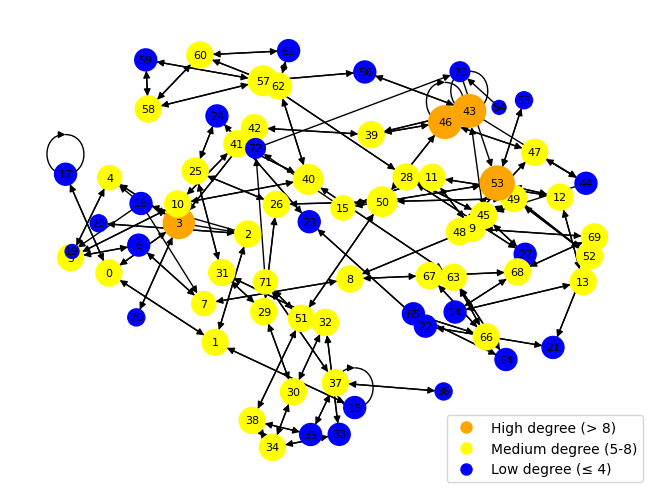

In [ ]:
# Draw the graph
pos = nx.spring_layout(G, k=0.5)  # Layout for the graph, k is the optimal distance between nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='black', node_size=node_sizes, font_size=8)
plt.legend(handles=legend_elements, loc='best')

plt.show()

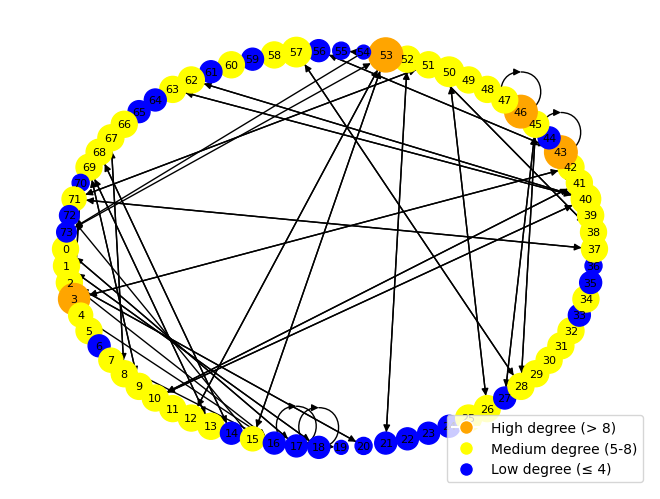

In [ ]:
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='black', node_size=node_sizes, font_size=8)
plt.legend(handles=legend_elements, loc='best')

plt.show()

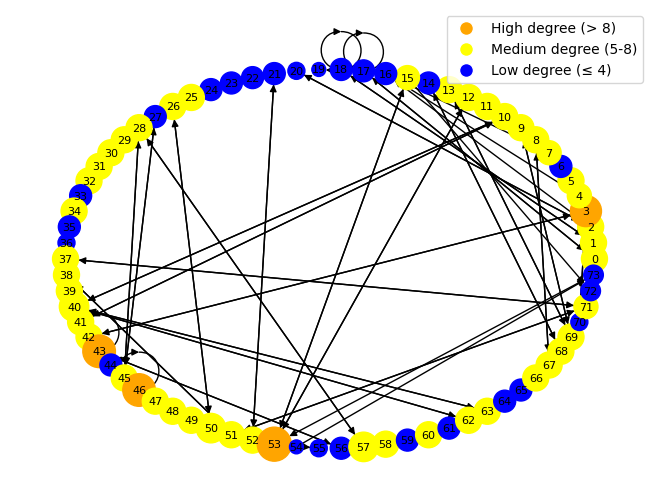

In [ ]:
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='black', node_size=node_sizes, font_size=8)
plt.legend(handles=legend_elements, loc='best')

plt.show()

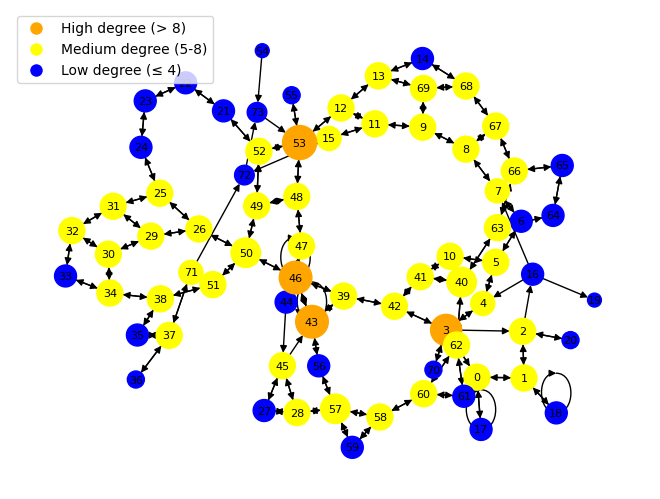

In [ ]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='black', node_size=node_sizes, font_size=8)
plt.legend(handles=legend_elements, loc='best')

plt.show()

In [ ]:
# Function to create a directory if it doesn't already exist
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

# Created a directory  for model saving
output_dir = '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/models'
create_directory(output_dir)

output_dir = '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6'
create_directory(output_dir)


Directory '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/models' already exists.
Directory '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6' created.


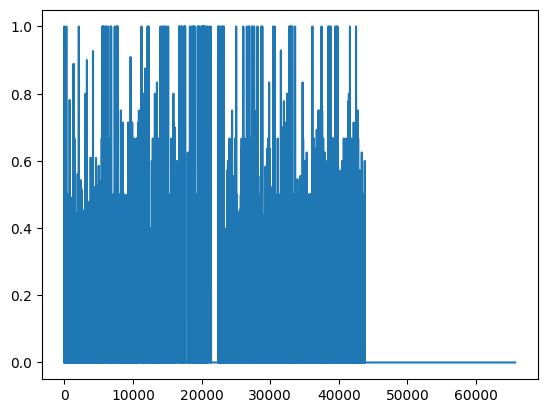

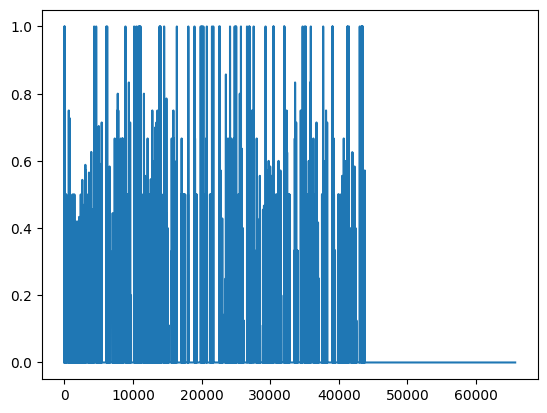

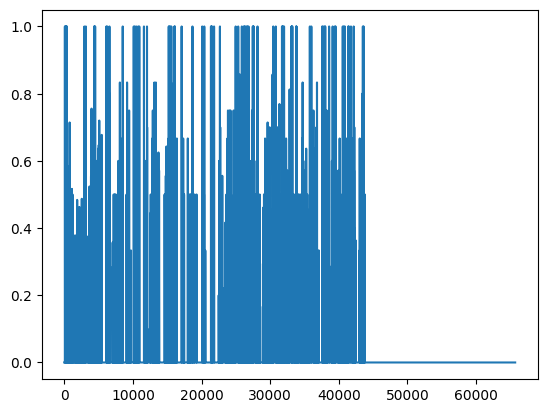

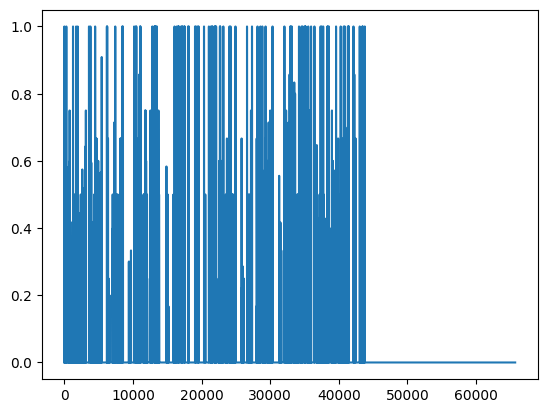

In [ ]:
for i in train_loader:
  adj_mat = i[1]
  # print(adj_mat[:, :12, :, :])
  plt.plot(adj_mat[:, :12, :, :][0].cpu().flatten())
  plt.show()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

Scenario 1 model training
Epoch [1/20], D Loss: 0.5345, G Loss: 155.6831
Epoch [2/20], D Loss: 0.1899, G Loss: 125.3450
Epoch [3/20], D Loss: 0.2719, G Loss: 93.1224
Epoch [4/20], D Loss: 0.4017, G Loss: 58.0828
Epoch [5/20], D Loss: 0.1740, G Loss: 39.6701
Epoch [6/20], D Loss: 0.3237, G Loss: 32.6197
Epoch [7/20], D Loss: 0.1936, G Loss: 32.6673
Epoch [8/20], D Loss: 0.2797, G Loss: 32.6260
Epoch [9/20], D Loss: 0.2343, G Loss: 33.4705
Epoch [10/20], D Loss: 0.2071, G Loss: 33.7310
Epoch [11/20], D Loss: 0.1268, G Loss: 33.4829
Epoch [12/20], D Loss: 0.1771, G Loss: 33.7432
Epoch [13/20], D Loss: 0.0433, G Loss: 33.1798
Epoch [14/20], D Loss: 0.0547, G Loss: 32.8588
Epoch [15/20], D Loss: 0.1633, G Loss: 33.1987
Epoch [16/20], D Loss: 0.0164, G Loss: 32.4770
Epoch [17/20], D Loss: 0.0879, G Loss: 32.3689
Epoch [18/20], D Loss: 0.0383, G Loss: 32.2643
Epoch [19/20], D Loss: 0.0578, G Loss: 31.9165
Epoch [20/20], D Loss: 0.2051, G Loss: 32.5599


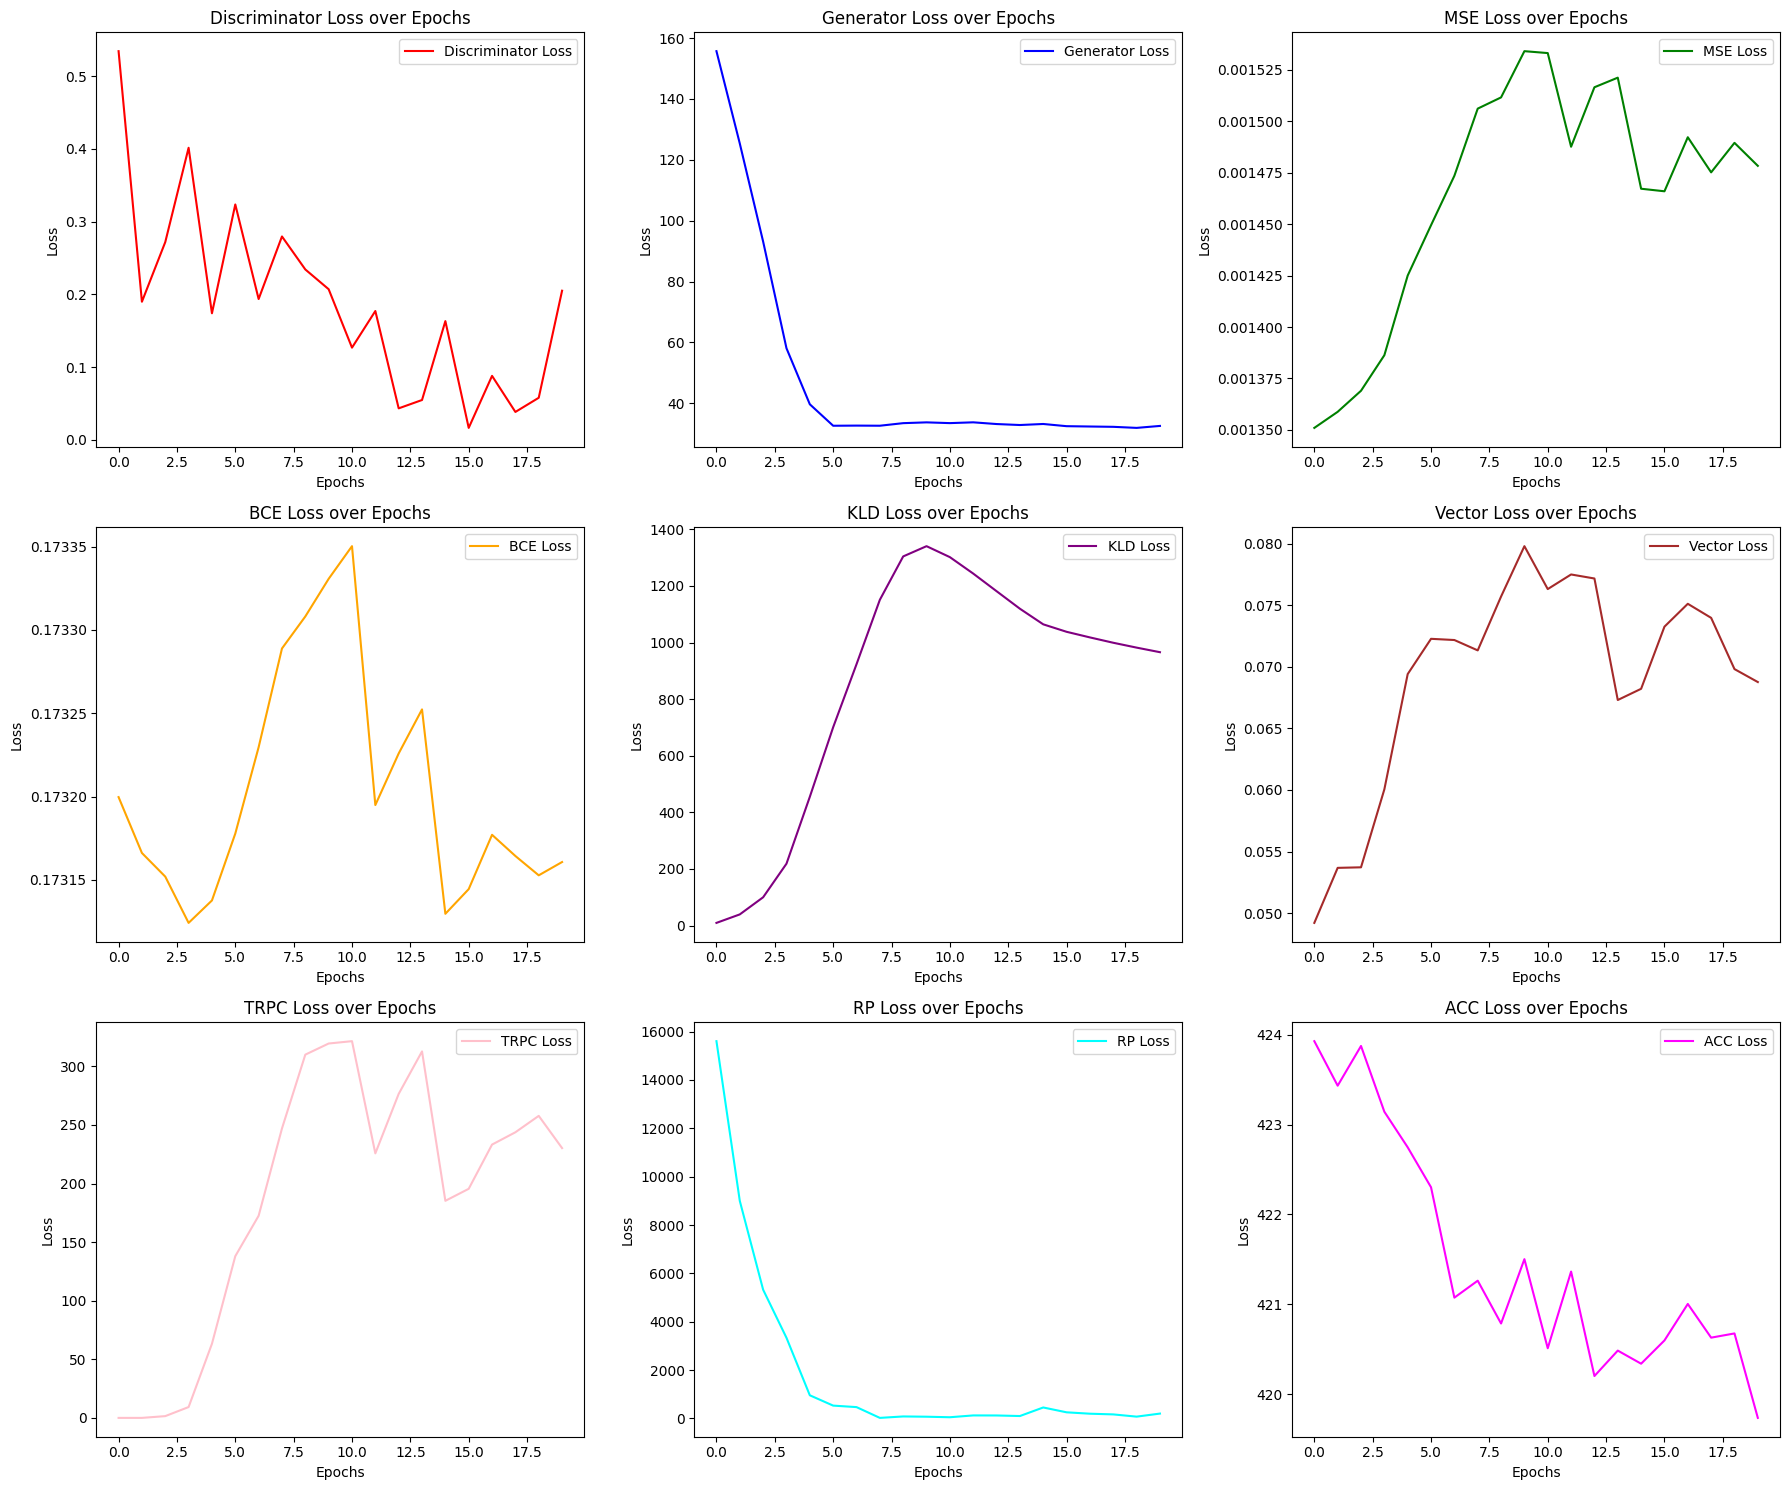

Test Loss: 25.437393188476562
-------------------------
Scenario 2 model training
Epoch [1/20], D Loss: 0.7600, G Loss: 153.8017
Epoch [2/20], D Loss: 1.0519, G Loss: 133.1812
Epoch [3/20], D Loss: 0.9494, G Loss: 104.4559
Epoch [4/20], D Loss: 0.4063, G Loss: 78.6718
Epoch [5/20], D Loss: 0.5022, G Loss: 51.0461
Epoch [6/20], D Loss: 0.7298, G Loss: 38.2349
Epoch [7/20], D Loss: 0.2036, G Loss: 37.6729
Epoch [8/20], D Loss: 0.3203, G Loss: 35.3066
Epoch [9/20], D Loss: 0.5507, G Loss: 32.5562
Epoch [10/20], D Loss: 0.3757, G Loss: 33.4465
Epoch [11/20], D Loss: 0.3482, G Loss: 33.8631
Epoch [12/20], D Loss: 0.3301, G Loss: 34.1336
Epoch [13/20], D Loss: 0.3771, G Loss: 34.2769
Epoch [14/20], D Loss: 0.3419, G Loss: 33.9608
Epoch [15/20], D Loss: 0.0683, G Loss: 33.4629
Epoch [16/20], D Loss: 0.3849, G Loss: 33.1969
Epoch [17/20], D Loss: 0.1402, G Loss: 33.5269
Epoch [18/20], D Loss: 0.2565, G Loss: 32.7849
Epoch [19/20], D Loss: 0.5309, G Loss: 33.2894
Epoch [20/20], D Loss: 0.3794, 

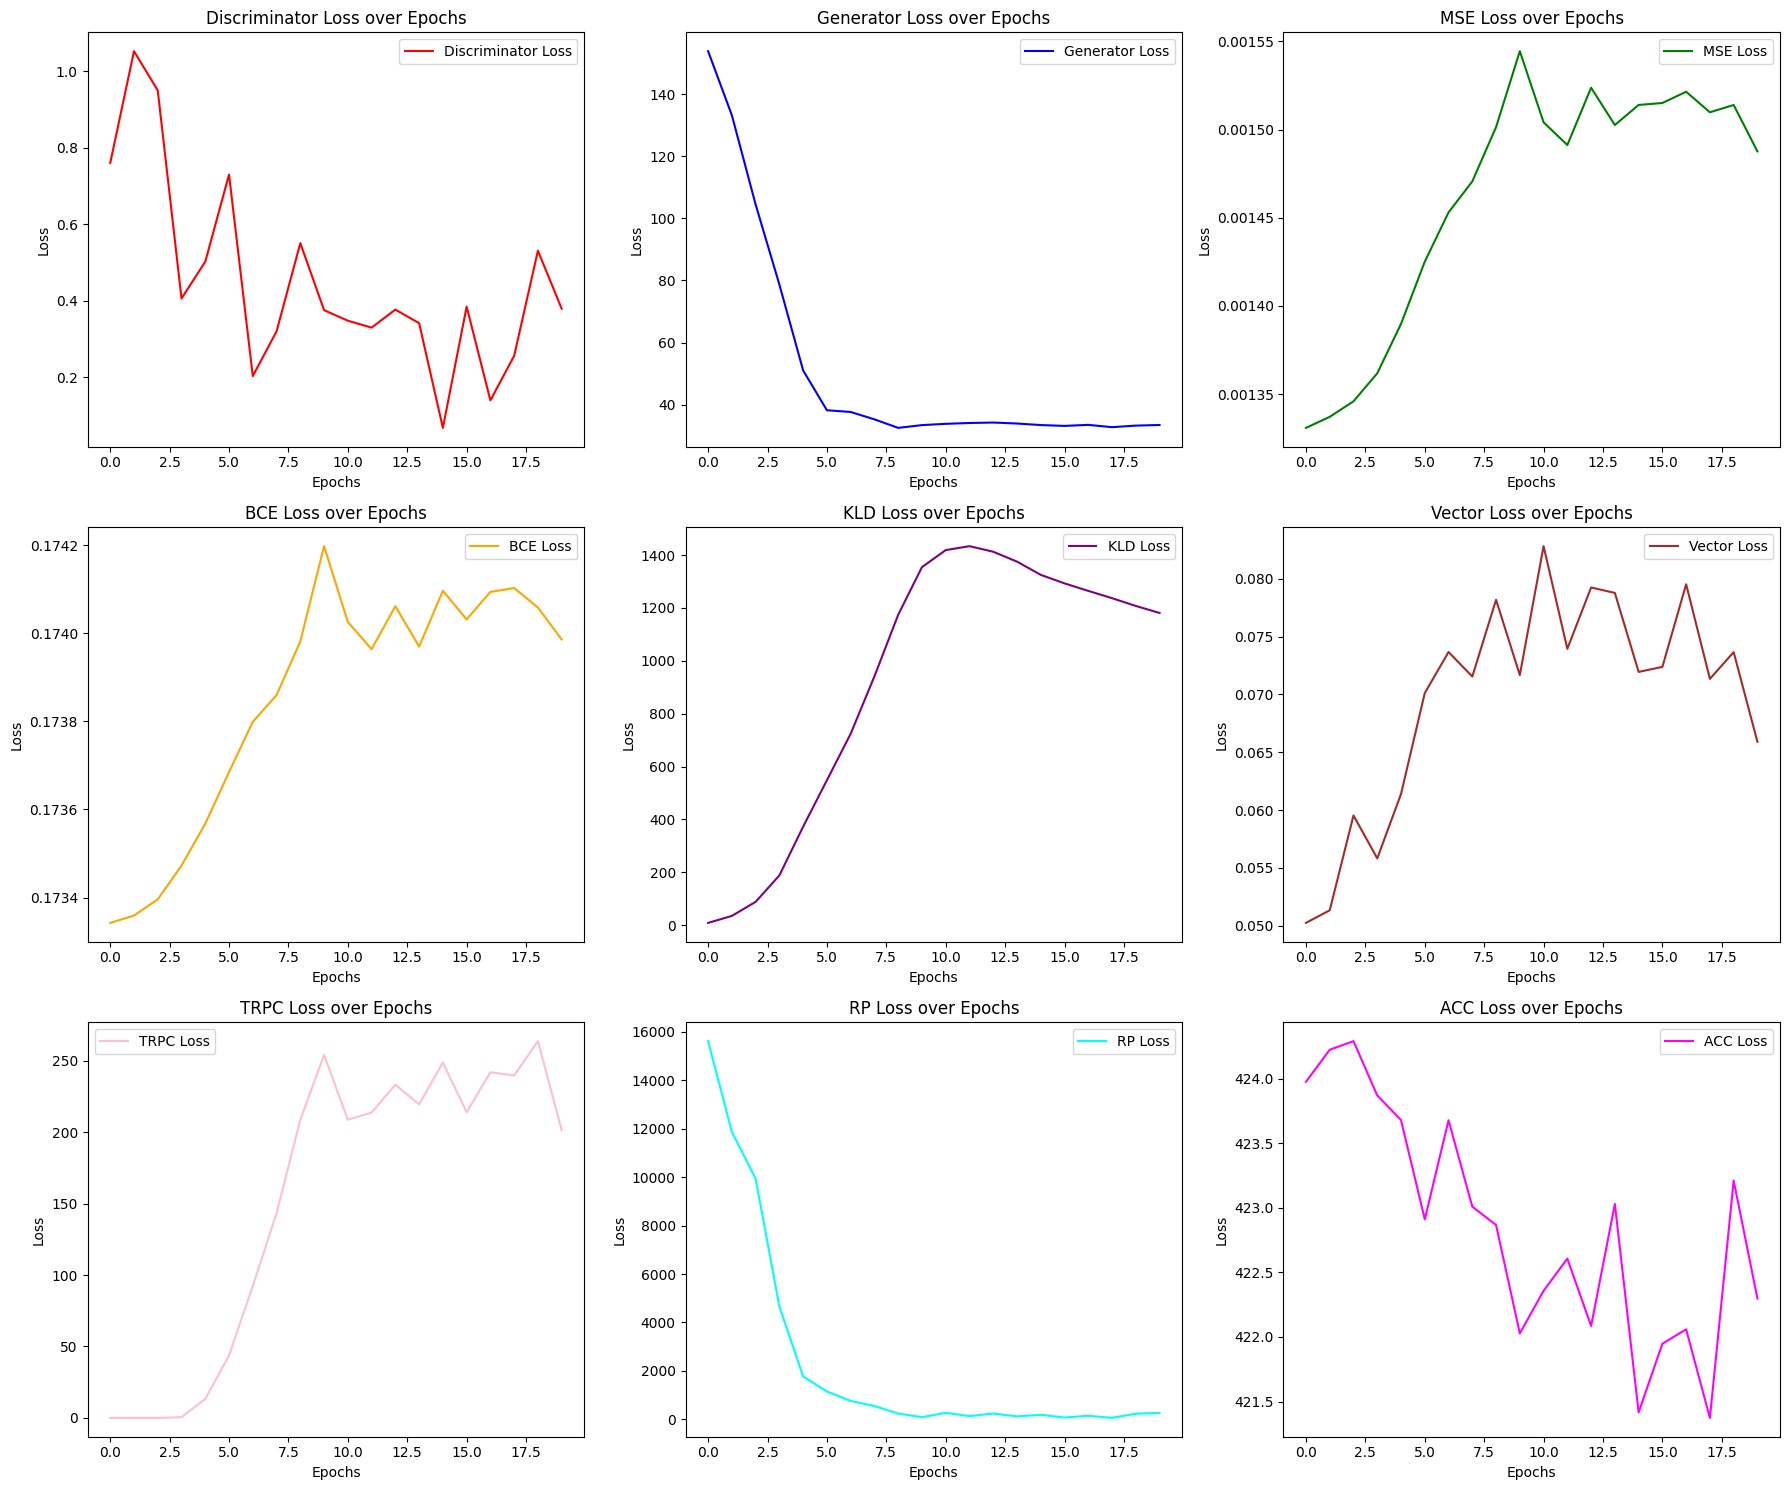

Test Loss: 24.879802703857422
-------------------------
Scenario 3 model training
Epoch [1/20], D Loss: 0.9689, G Loss: 154.2944
Epoch [2/20], D Loss: 0.9097, G Loss: 135.0045
Epoch [3/20], D Loss: 0.4882, G Loss: 108.7463
Epoch [4/20], D Loss: 0.3882, G Loss: 90.7932
Epoch [5/20], D Loss: 0.1128, G Loss: 65.8955
Epoch [6/20], D Loss: 0.2699, G Loss: 51.1702
Epoch [7/20], D Loss: 0.3513, G Loss: 45.7273
Epoch [8/20], D Loss: 0.4637, G Loss: 42.4370
Epoch [9/20], D Loss: 0.1824, G Loss: 36.5739
Epoch [10/20], D Loss: 0.2860, G Loss: 33.6736
Epoch [11/20], D Loss: 0.1796, G Loss: 32.1175
Epoch [12/20], D Loss: -0.1239, G Loss: 32.8641
Epoch [13/20], D Loss: 0.3596, G Loss: 32.4368
Epoch [14/20], D Loss: 0.0862, G Loss: 32.9186
Epoch [15/20], D Loss: 0.0719, G Loss: 32.7517
Epoch [16/20], D Loss: 0.1915, G Loss: 32.1069
Epoch [17/20], D Loss: 0.2317, G Loss: 32.7074
Epoch [18/20], D Loss: 0.0874, G Loss: 32.5727
Epoch [19/20], D Loss: -0.0060, G Loss: 33.5887
Epoch [20/20], D Loss: 0.2095

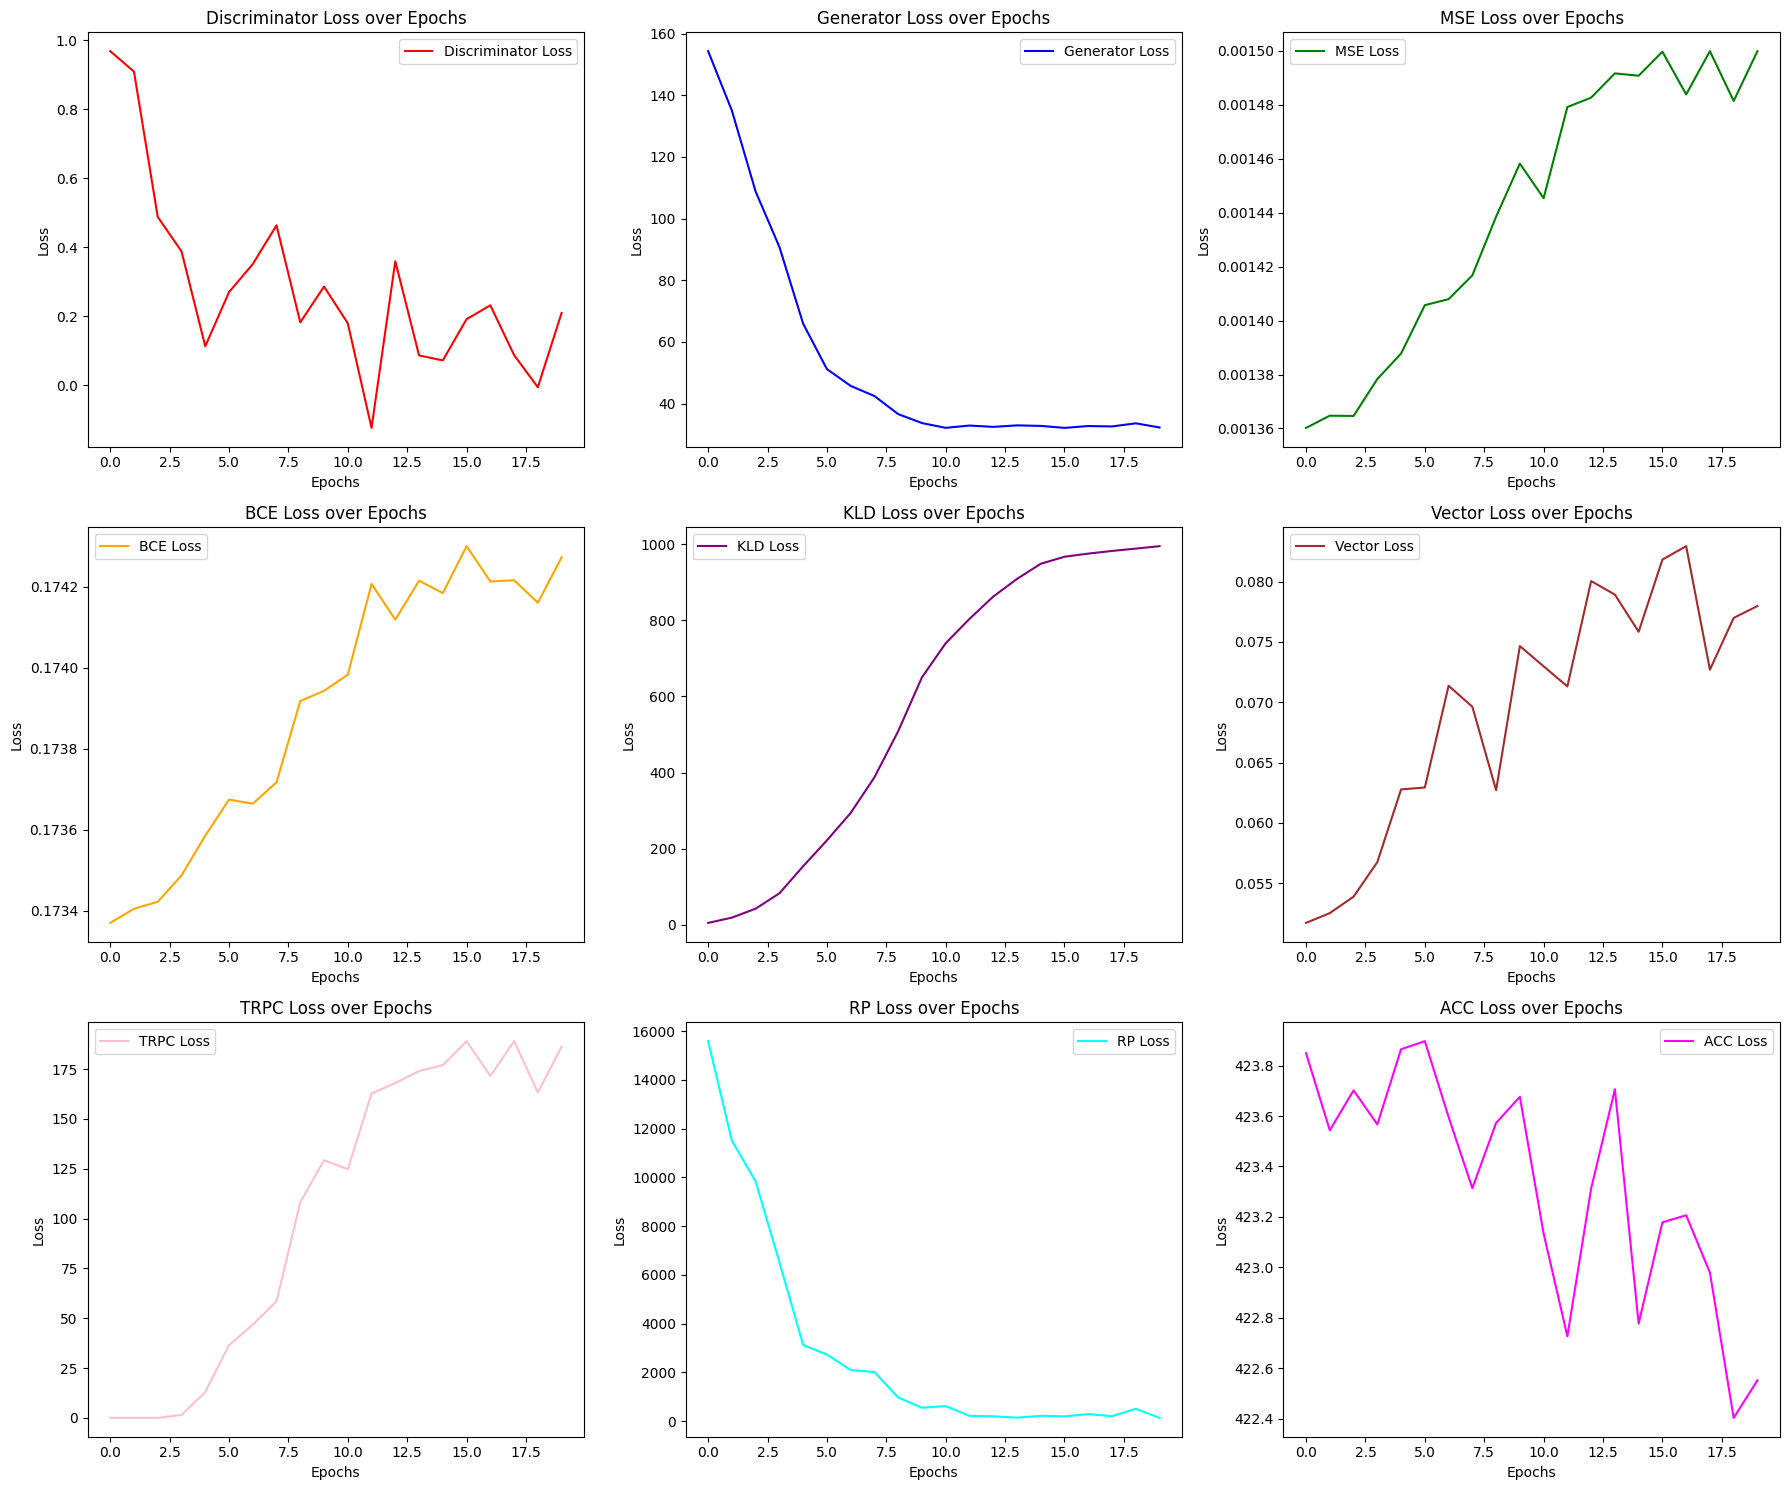

Test Loss: 24.302358627319336
-------------------------
Scenario 4 model training
Epoch [1/20], D Loss: 1.9726, G Loss: 158.8748
Epoch [2/20], D Loss: 2.4951, G Loss: 132.0247
Epoch [3/20], D Loss: 2.2369, G Loss: 106.3915
Epoch [4/20], D Loss: 1.7064, G Loss: 70.4250
Epoch [5/20], D Loss: 1.1271, G Loss: 51.9930
Epoch [6/20], D Loss: 1.5251, G Loss: 41.5055
Epoch [7/20], D Loss: 1.1704, G Loss: 34.2678
Epoch [8/20], D Loss: 1.2713, G Loss: 33.2192
Epoch [9/20], D Loss: 1.1847, G Loss: 33.8833
Epoch [10/20], D Loss: 0.9838, G Loss: 34.4545
Epoch [11/20], D Loss: 0.9142, G Loss: 34.1523
Epoch [12/20], D Loss: 0.8288, G Loss: 33.4074
Epoch [13/20], D Loss: 1.0966, G Loss: 33.9396
Epoch [14/20], D Loss: 1.2914, G Loss: 33.4035
Epoch [15/20], D Loss: 1.1116, G Loss: 33.6098
Epoch [16/20], D Loss: 0.8330, G Loss: 33.8412
Epoch [17/20], D Loss: 0.6347, G Loss: 33.6580
Epoch [18/20], D Loss: 0.3020, G Loss: 34.2000
Epoch [19/20], D Loss: 0.6331, G Loss: 33.4470
Epoch [20/20], D Loss: 0.9422, 

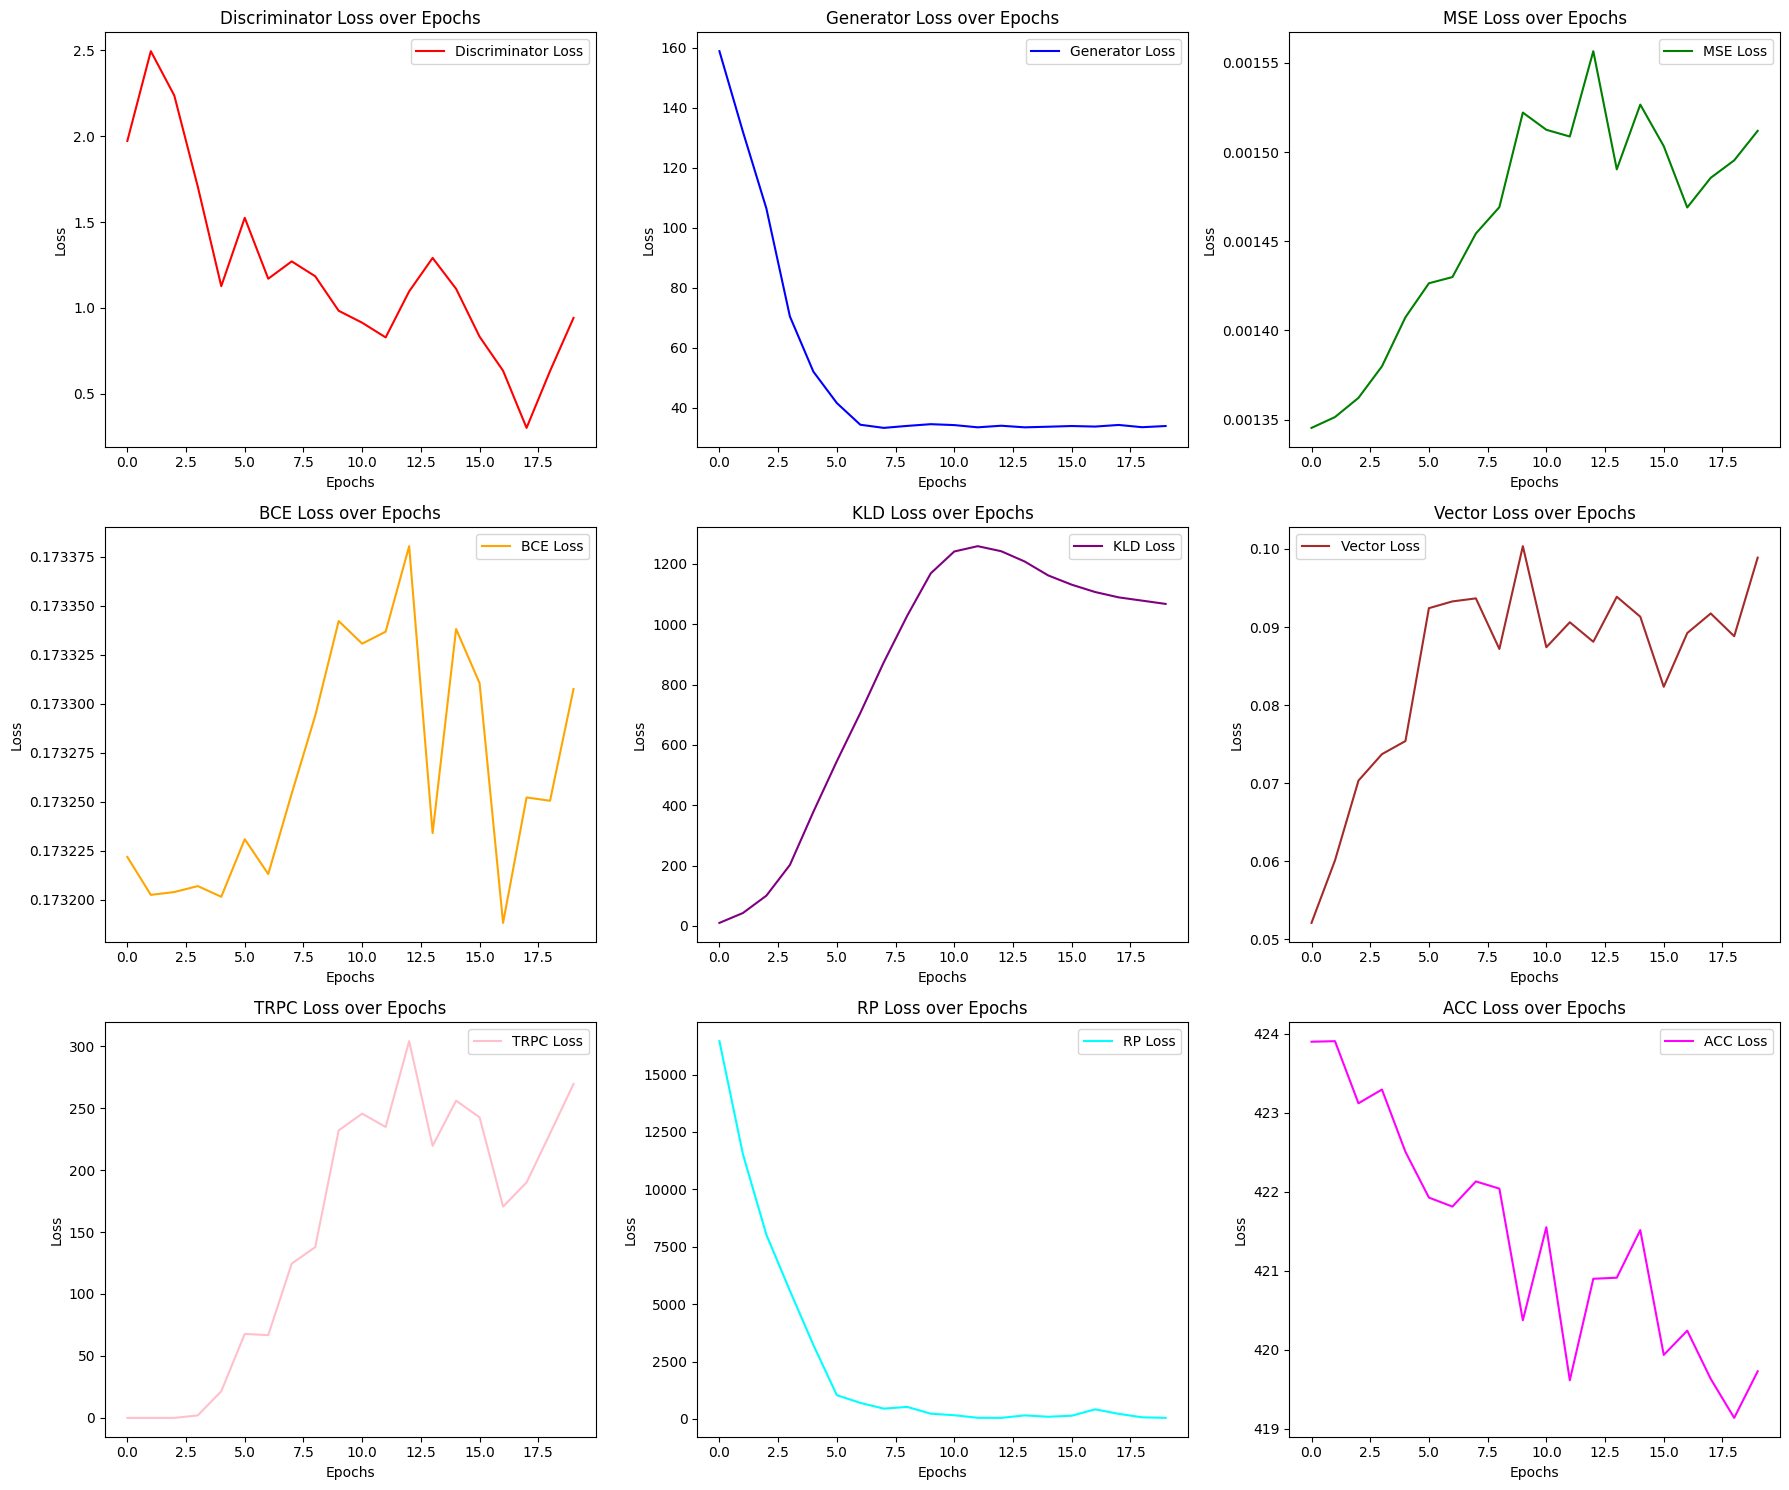

Test Loss: 25.575733184814453
-------------------------
Scenario 5 model training
Epoch [1/20], D Loss: 1.4722, G Loss: 157.5615
Epoch [2/20], D Loss: 0.8200, G Loss: 130.0720
Epoch [3/20], D Loss: 1.5019, G Loss: 103.7955
Epoch [4/20], D Loss: 0.8955, G Loss: 75.7271
Epoch [5/20], D Loss: 0.3316, G Loss: 47.7159
Epoch [6/20], D Loss: 0.5304, G Loss: 39.9669
Epoch [7/20], D Loss: 0.4722, G Loss: 34.2648
Epoch [8/20], D Loss: 0.3400, G Loss: 32.8587
Epoch [9/20], D Loss: 0.4698, G Loss: 33.6205
Epoch [10/20], D Loss: 0.0798, G Loss: 34.2697
Epoch [11/20], D Loss: 0.0603, G Loss: 34.1183
Epoch [12/20], D Loss: 0.2628, G Loss: 34.4275
Epoch [13/20], D Loss: 0.2558, G Loss: 34.1905
Epoch [14/20], D Loss: 0.0987, G Loss: 34.1632
Epoch [15/20], D Loss: 0.1648, G Loss: 33.9816
Epoch [16/20], D Loss: 0.5132, G Loss: 33.4914
Epoch [17/20], D Loss: 0.2665, G Loss: 33.9297
Epoch [18/20], D Loss: 0.1079, G Loss: 33.0775
Epoch [19/20], D Loss: 0.2415, G Loss: 33.1554
Epoch [20/20], D Loss: 0.1679, 

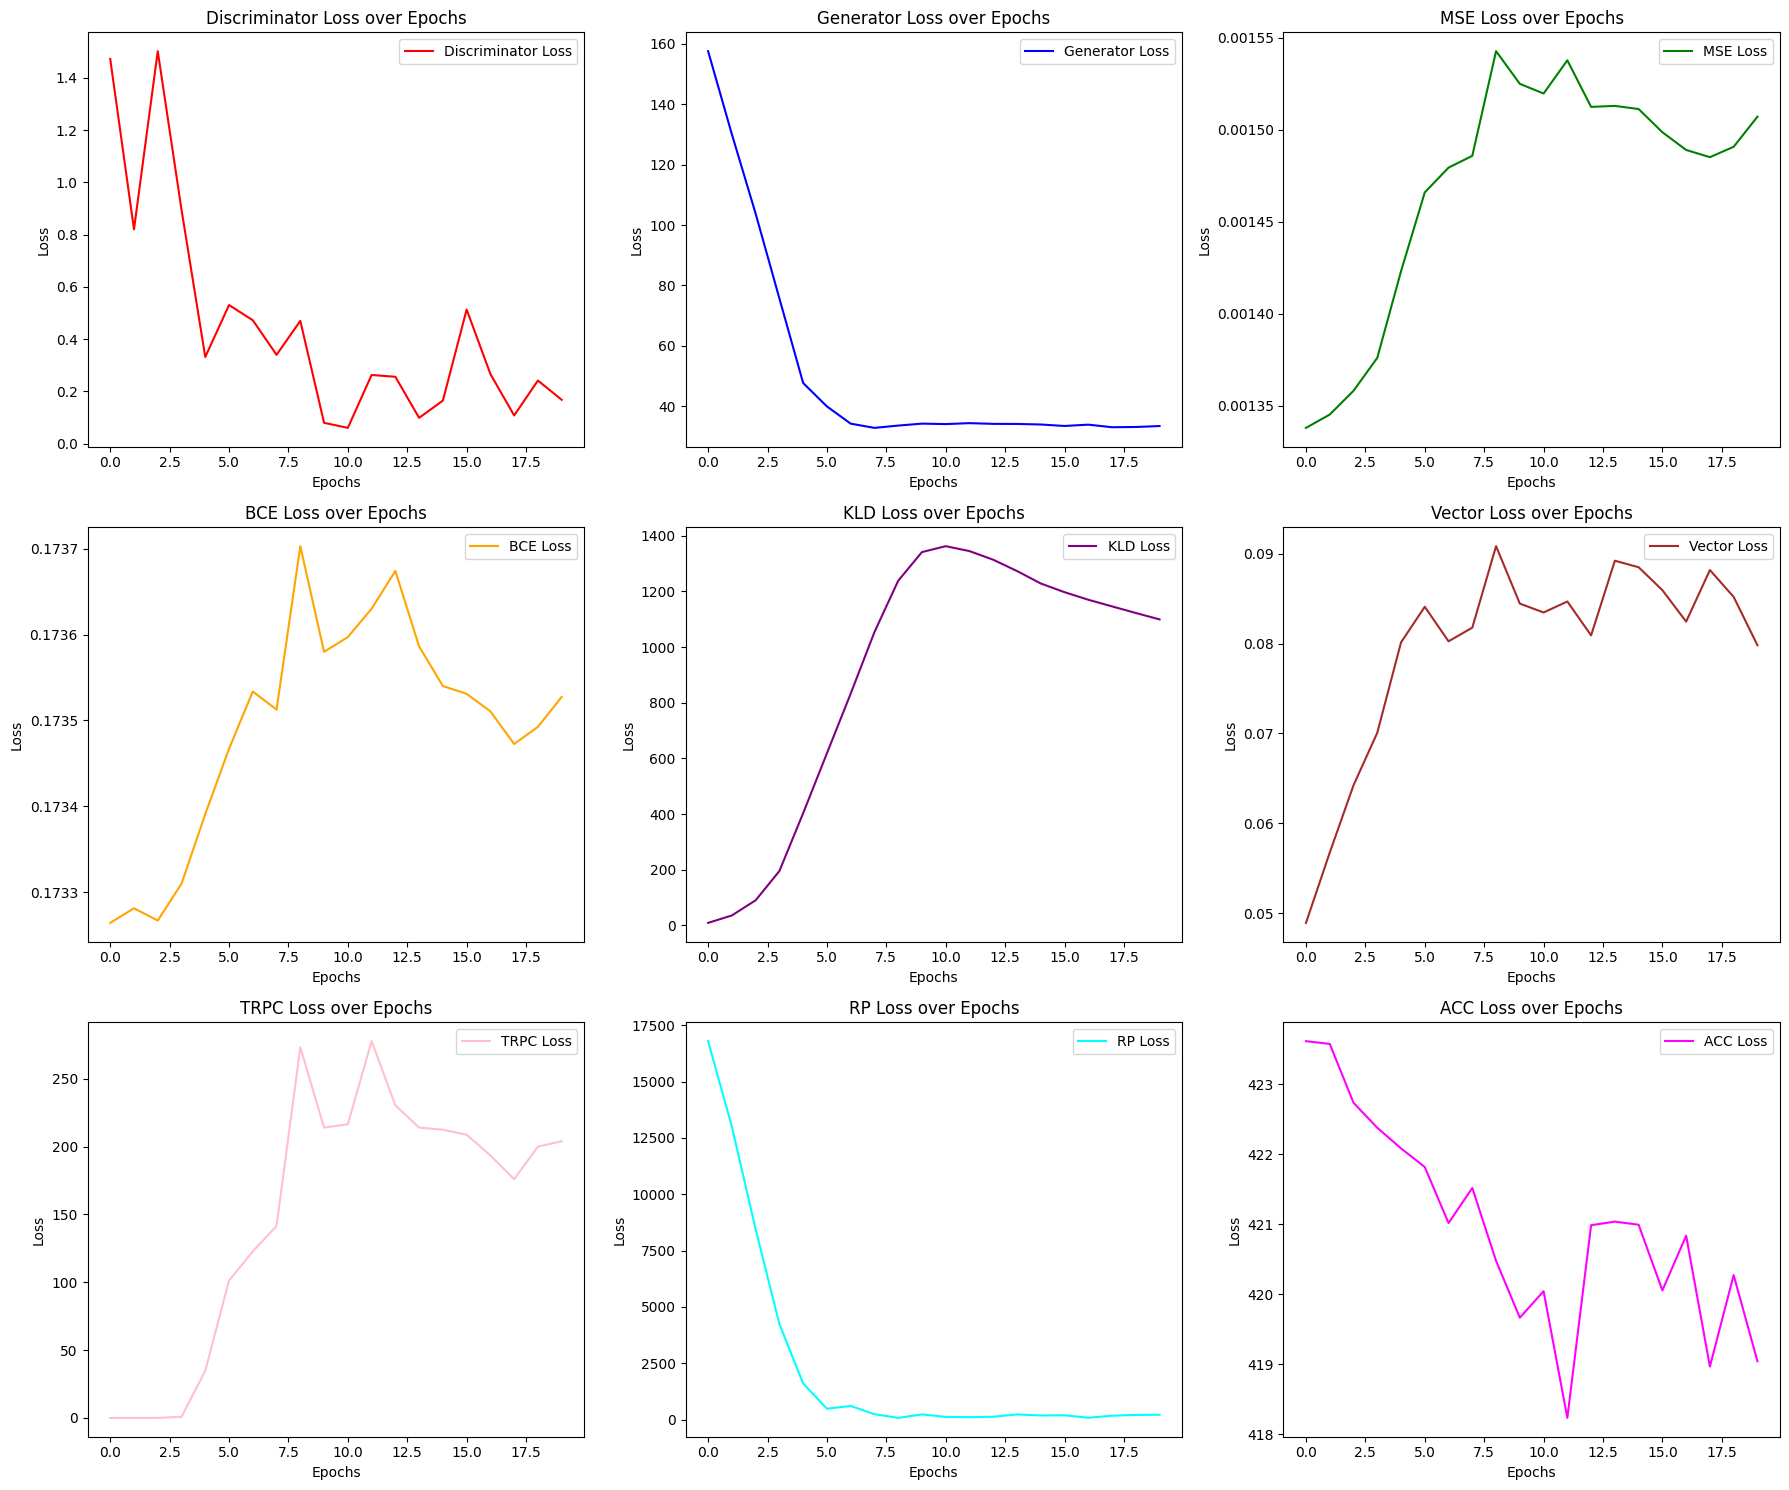

Test Loss: 25.140689849853516
-------------------------


In [ ]:
#WGAN-GP
models = {}
for i in range(1, 6):
  print(f"Scenario {i} model training")
  train_loader, test_loader = scenarios[i]
  generator, discriminator = train_test_with_synthesis_loss_fine_tuning(i, train_loader, test_loader, mse_loss=1000, bce_loss=1.0, kld_loss=1e-3, vector_loss=10, trpc_loss=1e-3, rp_loss=2*1e-3, acc_loss=1e-2, g_earth_mov=True, g_log_form=False)
  models[i] = (generator, discriminator)
  print("-------------------------")

In [ ]:
def test(generator, discriminator, data, g_earth_mov=True, g_log_form=False):
  criterion = nn.BCELoss(reduction='mean')
  custom_loss_fn = SynthesisLoss(1000, 1, 1e-3, 10, 1e-3, 2*1e-3, 1e-2)
  generator.eval()
  discriminator.eval()
  with torch.no_grad():
      test_loss = 0
      for adj_mats1, adj_mats2, seq_node_vec, node_vector in data:
        adj_mats1, adj_mats2, seq_node_vec, node_vector = adj_mats1.to(device), adj_mats2.to(device), seq_node_vec.to(device), node_vector.to(device)
        print(adj_mats1.shape, seq_node_vec.shape)
        real_labels = torch.ones(adj_mats1.size(0), 1).to(device)
        synthesis_adj_mat, synthesis_node_vector, mu, logvar = generator(seq_node_vec,adj_mats1,adj_mats1[:,-1,:,:,:])
        synthesis_adj_mat = existing_edge_maintainence(synthesis_adj_mat, network_info)

        synthesis_adj_mat[:, :12, :, :] = torch.softmax(synthesis_adj_mat[:, :12, :, :], dim=-1) #each row
        # synthesis_adj_mat[:, :12, :, :] = torch.softmax(synthesis_adj_mat[:, :12, :, :], dim=-2) #each col
        synthesis_adj_mat[:, 12:, :, :] = torch.sigmoid(synthesis_adj_mat[:, 12:, :, :])
        synthesis_node_vector = torch.sigmoid(synthesis_node_vector)


        outputs_adj_fake, outputs_vec_fake = discriminator(synthesis_adj_mat.detach(), synthesis_node_vector.detach())
        if g_earth_mov:
            g_loss = -torch.mean(outputs_adj_fake) - torch.mean(outputs_vec_fake)
        elif g_log_form:
            g_loss = torch.mean(torch.log(1 - outputs_adj_fake)) + torch.mean(torch.log(1 - outputs_vec_fake))
        test_loss += g_loss + custom_loss_fn(synthesis_adj_mat, adj_mats2, synthesis_node_vector, node_vector, mu, logvar)[0]

      test_loss /= len(data)
      print(f"Test Loss: {test_loss}")

  return synthesis_adj_mat, synthesis_node_vector



In [ ]:
norms_info

{'Vol': [0.0, 112.6]}

In [ ]:
def post_test_apply(synthesis_adj_mat, synthesis_node_vector):
    # print("post",synthesis_adj_mat[:, 12:, :, :].cpu().numpy().mean())
    sliced_array = synthesis_adj_mat[:, 12:, :, :].cpu().numpy()
    mean_value = sliced_array.mean()
    boolean_array = sliced_array > mean_value
    modified_array = boolean_array.astype(int)

    synthesis_adj_mat[:, 12:, :, :] = torch.tensor(modified_array, dtype=torch.float32, device=synthesis_adj_mat.device)

    # for i in range(12):
    #   synthesis_adj_mat[:,:i,:,:] = synthesis_adj_mat[:,:i,:,:]*torch.tensor(norms_info[keys[i]][1]) + torch.tensor(norms_info[keys[i]][0])

    # synthesis_node_vector = (synthesis_node_vector * norms_info['Vol'][1] + norms_info['Vol'][0]).to(torch.int64)

    # for i in range(12):
    #   synthesis_adj_mat[:,:i,:,:] = synthesis_adj_mat[:,:i,:,:]*(torch.tensor(norms_info[keys[i]][1]) - torch.tensor(norms_info[keys[i]][0])) + torch.tensor(norms_info[keys[i]][0])

    synthesis_node_vector = (synthesis_node_vector * (norms_info['Vol'][1] - norms_info['Vol'][0]) + norms_info['Vol'][0]).to(torch.int64)


    return synthesis_adj_mat, synthesis_node_vector


In [ ]:
import torch
import numpy as np
from scipy.stats import mode

def ensemble(models, data):
    adj_matrices = []
    node_vectors = []

    for i in range(1, 6):
        generator, discriminator = models[i]
        mat, vector = test(generator, discriminator, data)
        mat, vector = post_test_apply(mat, vector)
        adj_matrices.append(mat.clone().detach())
        node_vectors.append(vector.clone().detach())

    # Convert lists to tensors for easy manipulation
    adj_matrices = torch.stack(adj_matrices)
    node_vectors = torch.stack(node_vectors).float()  # Convert node vectors to float

    # Separate and average ratio features (first 12)
    ratio_features = adj_matrices[:, :, :12, :, :]
    averaged_ratio_features = torch.mean(ratio_features, dim=0)

    # Handle categorical features using majority voting
    categorical_features = adj_matrices[:, :, 12:, :, :].cpu().numpy()
    voted_categorical = np.apply_along_axis(lambda x: mode(x)[0], axis=0, arr=categorical_features)

    # Convert voted categorical features back to tensor
    voted_categorical_tensor = torch.tensor(voted_categorical).to(adj_matrices.device)

    # Combine ratio and categorical features
    combined_adj_mat = torch.cat((averaged_ratio_features, voted_categorical_tensor), dim=1)

    # Average the node vectors and round to nearest integer
    combined_node_vector = torch.mean(node_vectors, dim=0).round().to(torch.int)

    return combined_adj_mat, combined_node_vector


In [ ]:
def adj_to_df(base_graph, adj_matrix, nodes_encoder):
    row_wise_data = []
    for i in range(len(base_graph)):
        row = base_graph.iloc[i, :]
        link = row.Link
        starting_node = row.StartingNode
        ending_node = row.EndingNode
        node_pair = (nodes_encoder[starting_node], nodes_encoder[ending_node])
        features = adj_matrix[node_pair[0], node_pair[1]].cpu().detach().numpy()
        row_wise_data.append([link, starting_node, ending_node] + features.tolist())

    # Create the Turning Ratio columns
    TR = ['Turning Ratio(ALL)']
    for i in range(1, 12):
        TR.append(f'Turning Ratio({i})')
    # Define column names
    columns = ['Link', 'StartingNode', 'EndingNode'] + TR + [f'A_Veh{i}' for i in range(1, 12)]

    df = pd.DataFrame(row_wise_data, columns=columns)

    # Convert feature columns to integer
    convert_dict = {'A_Veh1':int,'A_Veh2':int,'A_Veh3':int,'A_Veh4':int,'A_Veh5':int,'A_Veh6':int,'A_Veh7':int,'A_Veh8':int,'A_Veh9':int,'A_Veh10':int,'A_Veh11':int}
    df = df.astype(convert_dict)

    return df

In [ ]:
base_graph = pd.read_csv('edge-data-for-stage1.csv')
base_graph = base_graph[['Link', 'StartingNode', 'EndingNode']]

In [ ]:
def next_seq_gen(generator, discriminator, data):
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        adj_mats1, seq_node_vec = data[0].unsqueeze(0).to(device), data[1].unsqueeze(0).unsqueeze(-1).to(device)

        synthesis_adj_mat, synthesis_node_vector, mu, logvar = generator(seq_node_vec,adj_mats1,adj_mats1[:,-1,:,:,:])
        synthesis_adj_mat = existing_edge_maintainence(synthesis_adj_mat, network_info)

        synthesis_adj_mat[:, :12, :, :] = torch.softmax(synthesis_adj_mat[:, :12, :, :], dim=-1) #each row
        # synthesis_adj_mat[:, :12, :, :] = torch.softmax(synthesis_adj_mat[:, :12, :, :], dim=-2) #each col
        synthesis_adj_mat[:, 12:, :, :] = torch.sigmoid(synthesis_adj_mat[:, 12:, :, :])
        synthesis_node_vector = torch.sigmoid(synthesis_node_vector)

    return synthesis_adj_mat, synthesis_node_vector

import torch
import numpy as np
from scipy.stats import mode

def ensemble_seq_gen(models, data):
    adj_matrices = []
    node_vectors = []

    for i in range(1, 6):
        generator, discriminator = models[i]
        mat, vector = next_seq_gen(generator, discriminator, data)
        mat, vector = post_test_apply(mat, vector)
        adj_matrices.append(mat.clone().detach())
        node_vectors.append(vector.clone().detach())
    print("Check")
    # Convert lists to tensors for easy manipulation
    adj_matrices = torch.stack(adj_matrices)
    node_vectors = torch.stack(node_vectors).float()

    # Divide the ratio features (first 12) by 5
    ratio_features = adj_matrices[:, :, :12, :, :]
    averaged_ratio_features = torch.mean(ratio_features, dim=0)

    # Handle categorical features using majority voting
    categorical_features = adj_matrices[:, :, 12:, :, :].cpu().numpy()
    voted_categorical = np.apply_along_axis(lambda x: mode(x)[0], axis=0, arr=categorical_features)

    # Convert voted categorical features back to tensor
    voted_categorical_tensor = torch.tensor(voted_categorical).to(adj_matrices.device)

    # Combine ratio and categorical features
    combined_adj_mat = torch.cat((averaged_ratio_features, voted_categorical_tensor), dim=1)

    # Average the node vectors
    combined_node_vector = torch.mean(node_vectors, dim=0).round().to(torch.int)


    return combined_adj_mat, combined_node_vector


In [ ]:
def save_results(node_vec, adj_mat, node_vector_csv_path, adj_mat_csv_path, base_graph=base_graph, nodes_encoder=nodes_encoder):
  node_vec = node_vec.cpu().numpy().astype(int)
  node_data = []

  for i in range(len(node_vec)):
      node_data.append({'Nodes': nodes_decoder[i], 'Volume': node_vec[i]})

  node_results_next = pd.DataFrame(node_data)
  node_results_next.to_csv(node_vector_csv_path)

  edge_results_next = adj_to_df(base_graph, adj_mat.permute(1, 2, 0), nodes_encoder)
  edge_results_next.to_csv(adj_mat_csv_path)
  print("Results saved successfully")

In [ ]:
def show_results(node_vec, adj_mat, base_graph=base_graph, nodes_encoder=nodes_encoder):
  node_vec = node_vec.cpu().numpy().astype(int)
  node_data = []

  for i in range(len(node_vec)):
      node_data.append({'Nodes': nodes_decoder[i], 'Volume': node_vec[i]})

  node_results_next = pd.DataFrame(node_data)

  edge_results_next = adj_to_df(base_graph, adj_mat.permute(1, 2, 0), nodes_encoder)

  return node_results_next, edge_results_next

# Adj mat. + Node vector generation

In [ ]:
next_time_stamp_adj_mat, next_time_stamp_node_vector = ensemble(models, scenarios[1][1])

torch.Size([4, 3, 23, 74, 74]) torch.Size([4, 3, 74, 1])
torch.Size([1, 3, 23, 74, 74]) torch.Size([1, 3, 74, 1])
Test Loss: 25.73459243774414
torch.Size([4, 3, 23, 74, 74]) torch.Size([4, 3, 74, 1])
torch.Size([1, 3, 23, 74, 74]) torch.Size([1, 3, 74, 1])
Test Loss: 25.248489379882812
torch.Size([4, 3, 23, 74, 74]) torch.Size([4, 3, 74, 1])
torch.Size([1, 3, 23, 74, 74]) torch.Size([1, 3, 74, 1])
Test Loss: 24.690780639648438
torch.Size([4, 3, 23, 74, 74]) torch.Size([4, 3, 74, 1])
torch.Size([1, 3, 23, 74, 74]) torch.Size([1, 3, 74, 1])
Test Loss: 25.362117767333984
torch.Size([4, 3, 23, 74, 74]) torch.Size([4, 3, 74, 1])
torch.Size([1, 3, 23, 74, 74]) torch.Size([1, 3, 74, 1])
Test Loss: 25.89104652404785


In [ ]:
next_time_stamp_adj_mat[:, 12:, :, :].min(), next_time_stamp_adj_mat[:, 12:, :, :].max(), next_time_stamp_adj_mat[:, 12:, :, :].mean()

(tensor(0., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.9773, device='cuda:0'))

In [ ]:
V, A = show_results(next_time_stamp_node_vector[-1], next_time_stamp_adj_mat[-1])

In [ ]:
V

,Nodes,Volume
0,1,77
1,2,77
2,3,45
3,4,61
4,5,5
...,...,...
69,71,53
70,73,62
71,74,53
72,75,62


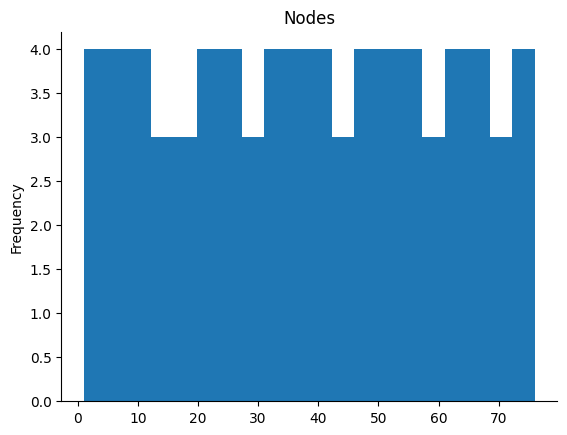

In [ ]:
from matplotlib import pyplot as plt
V['Nodes'].plot(kind='hist', bins=20, title='Nodes')
plt.gca().spines[['top', 'right',]].set_visible(False)

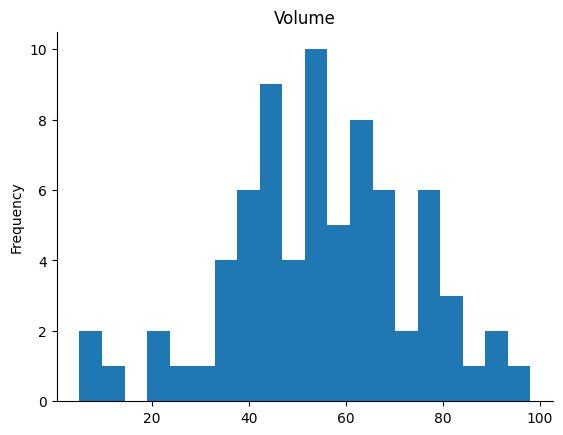

In [ ]:
from matplotlib import pyplot as plt
V['Volume'].plot(kind='hist', bins=20, title='Volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
A

,Link,StartingNode,EndingNode,Turning Ratio(ALL),Turning Ratio(1),Turning Ratio(2),Turning Ratio(3),Turning Ratio(4),Turning Ratio(5),Turning Ratio(6),...,A_Veh2,A_Veh3,A_Veh4,A_Veh5,A_Veh6,A_Veh7,A_Veh8,A_Veh9,A_Veh10,A_Veh11
0,10,25,26,0.577114,0.535431,0.450840,0.503314,0.314782,0.445864,0.516100,...,0,0,1,0,0,1,0,1,1,0
1,10,25,26,0.577114,0.535431,0.450840,0.503314,0.314782,0.445864,0.516100,...,0,0,1,0,0,1,0,1,1,0
2,1025,1,4,0.314845,0.375617,0.347198,0.423246,0.304896,0.319409,0.302769,...,0,0,1,1,0,1,0,1,1,0
3,1026,4,1,0.248222,0.158322,0.294602,0.123597,0.204188,0.247097,0.185126,...,0,0,1,0,1,1,0,1,1,0
4,1027,2,1,0.359609,0.262531,0.459668,0.312690,0.416091,0.325121,0.284059,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,951,61,59,0.453690,0.540959,0.496468,0.441924,0.454562,0.390225,0.462105,...,0,0,1,0,1,0,0,1,1,0
211,952,48,49,0.199433,0.156277,0.140991,0.159345,0.229859,0.214299,0.303683,...,0,0,0,1,0,1,0,1,1,0
212,953,49,48,0.284749,0.282383,0.340744,0.368077,0.424126,0.306039,0.360222,...,0,0,1,0,0,1,0,1,1,0
213,956,47,30,0.333215,0.257610,0.302771,0.413194,0.413285,0.245263,0.280347,...,0,0,1,0,0,1,0,1,1,1


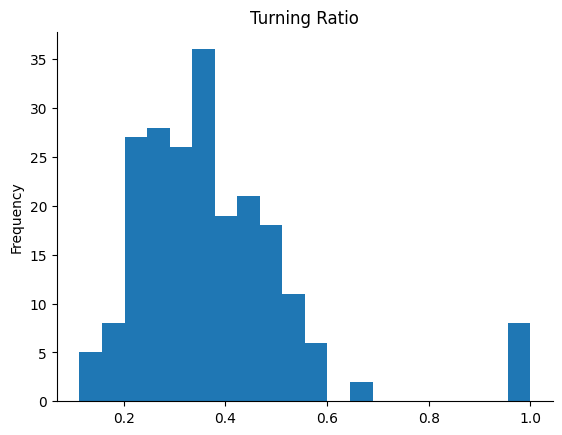

In [ ]:
from matplotlib import pyplot as plt
A['Turning Ratio(1)'].plot(kind='hist', bins=20, title='Turning Ratio')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
save_results(next_time_stamp_node_vector[-1], next_time_stamp_adj_mat[-1], '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/node_results_predict_timestamp1.csv', '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/edge_results_predict_timestamp1.csv')

Results saved successfully


In [ ]:
def TR_sum_constraint_loss(adj_mat):
  trsc_loss = 0
  channels = adj_mat.shape[0]
  rows = adj_mat.shape[1]
  for c in range(channels):
    for r in range(rows):
      trsc_loss += torch.abs(adj_mat[c][r].sum() - 1)
#       trsc_loss += torch.abs(adj_mat[c][:, r].sum() - 1)
  return trsc_loss

TR_sum_constraint_loss(next_time_stamp_adj_mat[-1][:12, :, :])

tensor(1.0371e-05, device='cuda:0')

In [ ]:
# adj = next_time_stamp_adj_mat[-1].cpu()[12:,:,:].flatten()

In [ ]:
# plt.bar([i for i in range(len(adj))], adj)

In [ ]:
def TR_permission_compatibility_loss(adj_matrix, penalty = 1, split_threshold=0.09):
  trpc_loss = 0
  split_threshold = adj_matrix.mean()
  for i in range(1,12):
    condition = ((adj_matrix[i, :, :] > 1e-5) & (adj_matrix[i+11, :, :] < split_threshold))
    trpc_loss+= penalty * condition.sum()
  return trpc_loss

TR_permission_compatibility_loss(next_time_stamp_adj_mat[-1])

tensor(1367, device='cuda:0')

# Sequence Generation for future time periods

In [ ]:
next_time_stamp_adj_mat1, next_time_stamp_node_vector1 = next_time_stamp_adj_mat[-1].unsqueeze(0), next_time_stamp_node_vector[-1].unsqueeze(0)

next_time_stamp_adj_mat2, next_time_stamp_node_vector2 = ensemble_seq_gen(models, (next_time_stamp_adj_mat1, next_time_stamp_node_vector1))
save_results(next_time_stamp_node_vector2.squeeze(0), next_time_stamp_adj_mat2.squeeze(0), '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/node_results_predict_timestamp2.csv', '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/edge_results_predict_timestamp2.csv')

next_time_stamp_adj_mat3, next_time_stamp_node_vector3 = ensemble_seq_gen(models, (next_time_stamp_adj_mat2, next_time_stamp_node_vector2))
save_results(next_time_stamp_node_vector3.squeeze(0), next_time_stamp_adj_mat3.squeeze(0), '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/node_results_predict_timestamp3.csv', '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/edge_results_predict_timestamp3.csv')

next_time_stamp_adj_mat4, next_time_stamp_node_vector4 = ensemble_seq_gen(models, (next_time_stamp_adj_mat3, next_time_stamp_node_vector3))
save_results(next_time_stamp_node_vector4.squeeze(0), next_time_stamp_adj_mat4.squeeze(0), '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/node_results_predict_timestamp4.csv', '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/edge_results_predict_timestamp4.csv')

next_time_stamp_adj_mat5, next_time_stamp_node_vector5 = ensemble_seq_gen(models, (next_time_stamp_adj_mat4, next_time_stamp_node_vector4))
save_results(next_time_stamp_node_vector5.squeeze(0), next_time_stamp_adj_mat5.squeeze(0), '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/node_results_predict_timestamp5.csv', '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/edge_results_predict_timestamp5.csv')


Check
Results saved successfully
Check
Results saved successfully
Check
Results saved successfully
Check
Results saved successfully


In [ ]:
def conditioned_blocking(adj_mat, blocking_condition, unblocking_condition):
  if blocking_condition != None:
    for condition in blocking_condition:
      start_node, end_node, veh_type = condition
      adj_mat[:, :, 11+veh_type, start_node, end_node] = torch.tensor(0, dtype=torch.float32)

  if unblocking_condition != None:
    for condition in unblocking_condition:
      start_node, end_node, veh_type = condition
      adj_mat[:, :, 11+veh_type, start_node, end_node] = torch.tensor(1, dtype=torch.float32)

  return adj_mat


In [ ]:
class lane_condition_loss(nn.Module):
  def __init__(self, l1, l2, l3):
    super(lane_condition_loss, self).__init__()
    self.l1 = l1
    self.l2 = l2
    self.l3 = l3

  def condition_loss(self, recon_adj_mat, adj_mat, blocking_condition, unblocking_condition):
    penalty = 0
    if blocking_condition != None:
      for condition in blocking_condition:
        start_node, end_node, veh_type = condition
        penalty+=(recon_adj_mat[:, 11+veh_type, start_node, end_node] - adj_mat[:, 11+veh_type, start_node, end_node])

    if unblocking_condition != None:
      for condition in unblocking_condition:
        start_node, end_node, veh_type = condition
        penalty+=(recon_adj_mat[:, 11+veh_type, start_node, end_node] - adj_mat[:, 11+veh_type, start_node, end_node])


    return penalty

  def TR_permission_compatibility_loss(self, adj_mat, penalty = 1):
      trpc_loss = 0
      split_threshold = adj_mat.mean()
      for i in range(1,12):
        condition = ((adj_mat[:, i, :, :] > 1e-5) & (adj_mat[:, i+11, :, :] < split_threshold))
        trpc_loss+= penalty * condition.sum()
      return trpc_loss

  def accumulation_loss(self, adj_mat):
      # Extract the diagonal elements along the last two dimensions
      diagonals = torch.diagonal(adj_mat, dim1=-2, dim2=-1)

      # Compute the absolute difference from 0 (diagonals should be close to 0)
      acc_loss = torch.abs(diagonals).sum()

      return acc_loss

  def forward(self, recon_adj_mat, recon_node_vec, adj_mat, blocking_condition, unblocking_condition):

      cond_loss = self.condition_loss(recon_adj_mat, adj_mat, blocking_condition, unblocking_condition)
      trpc_loss = self.TR_permission_compatibility_loss(recon_adj_mat)
      acc_loss = self.accumulation_loss(recon_adj_mat)
      total_loss = self.l1 * cond_loss + self.l2 * trpc_loss + self.l3 * acc_loss
      return total_loss.requires_grad_(True)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def conditioned_training(generator, adj_mat, node_vec, blocking_condition, unblocking_condition, epochs=5, learning_rate=1e-4):
    # Ensure the generator is in training mode
    generator.train()

    # Convert to appropriate device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    node_vec = node_vec.to(device, dtype=torch.float32)  # Ensure node_vec is float32
    adj_mat = adj_mat.to(device)

    # Ensure tensors require gradients
    adj_mat.requires_grad_(True)
    node_vec.requires_grad_(True)

    # Define a simple loss function and an optimizer
    lossobj = lane_condition_loss(10, 1, 1)
    optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

    # Define a learning rate scheduler
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(epochs):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        cond_adj_mat, cond_node_vec, _, _ = generator(node_vec, adj_mat, adj_mat[:, -1, :, :, :])

        # Calculate loss
        loss = lossobj(cond_adj_mat, cond_node_vec, adj_mat.squeeze(0), blocking_condition, unblocking_condition)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Step the scheduler
        # scheduler.step()

        # print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    # Put the generator in evaluation mode
    generator.eval()

    # Return the final generated adjacency matrix and node vector
    with torch.no_grad():
        cond_adj_mat, cond_node_vec, _, _ = generator(node_vec, adj_mat, adj_mat[:, -1, :, :, :])

    return cond_adj_mat, cond_node_vec



In [ ]:
def cond_next_seq_gen(generator, discriminator, data, blocking_condition=None, unblocking_condition=None):
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        adj_mats1, seq_node_vec = data[0].unsqueeze(0).to(device), data[1].unsqueeze(0).unsqueeze(-1).to(device)
        adj_mats1 = conditioned_blocking(adj_mats1, blocking_condition, unblocking_condition)
        synthesis_adj_mat, synthesis_node_vector = conditioned_training(generator, adj_mats1, seq_node_vec, blocking_condition, unblocking_condition)
        synthesis_adj_mat = existing_edge_maintainence(synthesis_adj_mat, network_info)

        synthesis_adj_mat[:, :12, :, :] = torch.softmax(synthesis_adj_mat[:, :12, :, :], dim=-1) #each row
        synthesis_adj_mat[:, 12:, :, :] = torch.sigmoid(synthesis_adj_mat[:, 12:, :, :])
        synthesis_node_vector = torch.sigmoid(synthesis_node_vector)

    return synthesis_adj_mat, synthesis_node_vector

import torch
import numpy as np
from scipy.stats import mode

def conditioned_seq_gen(models, data, blocking_condition, unblocking_condition):
    adj_matrices = []
    node_vectors = []

    for i in range(1, 6):
        print(f'Ensemble model {i} training....')
        generator, discriminator = models[i]
        mat, vector = cond_next_seq_gen(generator, discriminator, data, blocking_condition, unblocking_condition)
        mat, vector = post_test_apply(mat, vector)
        adj_matrices.append(mat.clone().detach())
        node_vectors.append(vector.clone().detach())

    # Convert lists to tensors for easy manipulation
    adj_matrices = torch.stack(adj_matrices)
    node_vectors = torch.stack(node_vectors).float()

    # Divide the ratio features (first 12) by 5
    ratio_features = adj_matrices[:, :, :12, :, :]
    averaged_ratio_features = torch.mean(ratio_features, dim=0)

    # Handle categorical features using majority voting
    categorical_features = adj_matrices[:, :, 12:, :, :].cpu().numpy()
    voted_categorical = np.apply_along_axis(lambda x: mode(x)[0], axis=0, arr=categorical_features)

    # Convert voted categorical features back to tensor
    voted_categorical_tensor = torch.tensor(voted_categorical).to(adj_matrices.device)

    # Combine ratio and categorical features
    combined_adj_mat = torch.cat((averaged_ratio_features, voted_categorical_tensor), dim=1)

    # Average the node vectors
    combined_node_vector = torch.mean(node_vectors, dim=0).round().to(torch.int)


    return combined_adj_mat, combined_node_vector


In [ ]:
def user_input():
  n = int(input("Enter the number of lanes want to block "))
  blocking_condition = []
  for i in range(n):
    blocking_condition.append((int(input("Enter the starting node")), int(input("Enter the ending node ")), int(input("Enter the vehicle type "))))

  m = int(input("Enter the number of lanes want to un-block "))
  unblocking_condition = []
  for i in range(m):
    unblocking_condition.append((int(input("Enter the starting node ")), int(input("Enter the ending node ")), int(input("Enter the vehicle type "))))

  return blocking_condition, unblocking_condition

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def allowed_lanes_record(adj_mat, veh_type):
    allowed_lanes = []
    mat = adj_mat[0][11 + veh_type]
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i][j] > 1e-5:
                allowed_lanes.append((i, j))
    return allowed_lanes

def visualize(adj_mat, veh_type, nodes_encoder, network_info):
    allowed_lanes = allowed_lanes_record(adj_mat, veh_type)

    # Create the directed graph
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(len(nodes_encoder))])
    G.add_edges_from(network_info)

    # Calculate node sizes based on degree (incoming + outgoing)
    node_sizes = [50 * (G.degree(n) + 1) for n in G.nodes()]

    # Determine node colors based on degree
    node_colors = []
    for n in G.nodes():
        degree = G.degree(n)
        if degree > 8:
            node_colors.append('orange')
        elif degree > 4:
            node_colors.append('yellow')
        else:
            node_colors.append('blue')

    # Determine edge colors based on allowed lanes
    edge_colors = ['green' if (u, v) in allowed_lanes else 'red' for u, v in G.edges()]

    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, node_size=node_sizes, font_size=8)

    # Create legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='High degree (> 8)', markersize=10, markerfacecolor='orange'),
        Line2D([0], [0], marker='o', color='w', label='Medium degree (5-8)', markersize=10, markerfacecolor='yellow'),
        Line2D([0], [0], marker='o', color='w', label='Low degree (≤ 4)', markersize=10, markerfacecolor='blue'),
        Line2D([0], [0], color='green', lw=2, label='Allowed Lane'),
        Line2D([0], [0], color='red', lw=2, label='Not Allowed Lane')
    ]

    plt.legend(handles=legend_elements, loc='best')
    plt.show()

In [ ]:
# Create an interactive widget
interact(lambda veh_type: visualize(next_time_stamp_adj_mat5, veh_type, nodes_encoder, network_info), veh_type=veh_type_dropdown)

interactive(children=(Dropdown(description='Vehicle Type:', options=(('Vehicle Type 1', 1), ('Vehicle Type 2',…

<function __main__.<lambda>(veh_type)>

In [ ]:
blocking_condition, unblocking_condition = user_input()

next_time_stamp_adj_mat6, next_time_stamp_node_vector6 = conditioned_seq_gen(models, (next_time_stamp_adj_mat5, next_time_stamp_node_vector5), blocking_condition, unblocking_condition)

save_results(next_time_stamp_node_vector6.squeeze(0), next_time_stamp_adj_mat6.squeeze(0), '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/cond_node_results_predict_timestamp6.csv', '/content/drive/MyDrive/GenAI-for-Urban-Sustainable-Cities/Generated_stage3_v6/cond_edge_results_predict_timestamp6.csv')





Enter the number of lanes want to block 2
Enter the starting node71
Enter the ending node 72
Enter the vehicle type 1
Enter the starting node8
Enter the ending node 7
Enter the vehicle type 1
Enter the number of lanes want to un-block 1
Enter the starting node 36
Enter the ending node 37
Enter the vehicle type 1
Ensemble model 1 training....
Ensemble model 2 training....
Ensemble model 3 training....
Ensemble model 4 training....
Ensemble model 5 training....
Results saved successfully



In [ ]:
interact(lambda veh_type: visualize(next_time_stamp_adj_mat6, veh_type, nodes_encoder, network_info), veh_type=veh_type_dropdown)

interactive(children=(Dropdown(description='Vehicle Type:', options=(('Vehicle Type 1', 1), ('Vehicle Type 2',…

<function __main__.<lambda>(veh_type)>